# About Dataset

Ridership Data source: https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/

Station Location Data source: https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information

# Initialization

In [2]:
from datetime import datetime
import glob, os, math, requests, random
from haversine import haversine, Unit

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors

import seaborn as sns
import folium
from folium.plugins import MarkerCluster

green_color = "#4CAF50"

%matplotlib inline

In [3]:
# Function to generate a random color in hex format
def get_random_color():
    hue = random.random()  # Random float between 0 and 1 for hue
    saturation = 0.9 + random.random() * 0.1  # Saturation between 0.9 and 1 for vibrant colors
    value = 0.7 + random.random() * 0.3  # Value between 0.7 and 1 for brighter colors
    rgb_color = mcolors.hsv_to_rgb([hue, saturation, value])  # Convert HSV to RGB
    return mcolors.to_hex(rgb_color)  # Convert RGB to hex


# List of predefined colors that folium.Icon accepts
# !!! "white" is not included !!!
icon_colors = ['gray', 'lightgray', 'lightred', 'darkblue', 'blue', 'darkgreen', 
               'black', 'red', 'green', 'beige', 'lightgreen', 'darkred', 'orange', 
               'darkpurple', 'purple', 'cadetblue', 'lightblue', 'pink']

# Function to generate a random color from the list
def get_random_predefined_color():
    return random.choice(icon_colors)

In [4]:
# Specify the path and pattern for the CSV files
# This will look for all CSV files in the specified directory
csv_files = glob.glob('datasets/2018/*.csv')

# Create a list to hold the DataFrames
dataframes = []

# Loop through the list of file paths
for file in csv_files:
    # Read each CSV file and append the DataFrame to the list
    df = pd.read_csv(file)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame 
trips_df = pd.concat(dataframes, ignore_index=True)

trips_df.head(5)

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type
0,2383648,393,7018,1/1/2018 0:47,Bremner Blvd / Rees St,1/1/2018 0:54,7176,Bathurst St / Fort York Blvd,Annual Member
1,2383649,625,7184,1/1/2018 0:52,Ossington Ave / College St,1/1/2018 1:03,7191,Central Tech (Harbord St),Annual Member
2,2383650,233,7235,1/1/2018 0:55,Bay St / College St (West Side) - SMART,1/1/2018 0:59,7021,Bay St / Albert St,Annual Member
3,2383651,1138,7202,1/1/2018 0:57,Queen St W / York St (City Hall),1/1/2018 1:16,7020,Phoebe St / Spadina Ave,Annual Member
4,2383652,703,7004,1/1/2018 1:00,University Ave / Elm St,1/1/2018 1:12,7060,Princess St / Adelaide St E,Annual Member


In [5]:
# Check all null values in , if None we can proceed or deal with it if any
trips_df.isnull().sum()

trip_id                  0
trip_duration_seconds    0
from_station_id          0
trip_start_time          0
from_station_name        0
trip_stop_time           0
to_station_id            0
to_station_name          0
user_type                0
dtype: int64

# Adding locations to trips_df

In [6]:
# URL of the JSON data
url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information'

# Fetch the JSON data
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load JSON data
    data = response.json()
    
    # Convert JSON to DataFrame
    bike_stations_df = pd.json_normalize(data['data']['stations'])
    print("Data successfully fetched")
else:
    print(f"Failed to fetch data: {response.status_code}")

Data successfully fetched


In [7]:
bike_stations_df.head(2)

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,is_charging_station,rental_methods,groups,obcn,short_name,nearby_distance,_ride_code_support,post_code,is_valet_station,cross_street
0,7000,Fort York Blvd / Capreol Ct,REGULAR,43.639832,-79.395954,NaN,Fort York Blvd / Capreol Ct,47,False,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[South],647-643-9607,647-643-9607,500.0,True,NaN,NaN,NaN
1,7001,Wellesley Station Green P,ELECTRICBIKESTATION,43.664964,-79.383550,NaN,Yonge / Wellesley,23,True,"[KEY, TRANSITCARD, CREDITCARD, PHONE]","[E-Charging , South]",416-617-9576,416-617-9576,500.0,True,M4Y 1G7,NaN,NaN


In [8]:
bike_stations_df.shape

(851, 18)

Converting ID column to Integer

In [9]:
bike_stations_df['station_id'] = bike_stations_df['station_id'].astype(int)

In [10]:
# Delete the specified columns
columns_to_drop = ['physical_configuration', 'altitude', 'address','capacity', 'is_charging_station', 'rental_methods', 'groups', 'obcn', 'short_name', 'nearby_distance', '_ride_code_support', 'post_code', 'is_valet_station', 'cross_street']
bike_stations_df.drop(columns=columns_to_drop, inplace=True)
bike_stations_df.head(3)

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Wellesley Station Green P,43.664964,-79.383550
2,7002,St. George St / Bloor St W,43.667131,-79.399555


In [11]:
# Delete "IDs" in bike_stations_df that are not in trips_df
bike_stations_df = bike_stations_df[bike_stations_df['station_id'].isin(trips_df['from_station_id'])].reset_index(drop=True)

# Display the filtered DataFrame
bike_stations_df.head(5)
print(bike_stations_df.shape)

(330, 4)


Renaming bike stations to thier old names in 2018

In [12]:
# Create a mapping of station ID to station name from trips_df
name_mapping = trips_df[['from_station_id', 'from_station_name']].drop_duplicates().set_index('from_station_id')['from_station_name'].to_dict()

# Update the station names in bike_stations_df based on the mapping
bike_stations_df['name'] = bike_stations_df['station_id'].map(name_mapping).combine_first(bike_stations_df['name'])

In [13]:
bike_stations_df.head(3)

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Lower Jarvis St / The Esplanade,43.664964,-79.383550
2,7002,St. George St / Bloor St W,43.667131,-79.399555


List of coordinates of stations missing data, I mannualy found it

In [14]:
missing_coordinates = {
    # ID: [Name, LAT, LON]
    7060: ['Princess St / Adelaide St E',                   43.652364279365386, -79.38072119893286],
    7177: ['East Liberty St / Pirandello St',               43.639083,          -79.414222],
    7062: ['University Ave / College St (West)',            43.659944,          -79.406389],
    7251: ['The Royal Ontario Museum (Bloor St Entrance)',  43.668444,          -79.405028],
    7011: ['Portland St & Wellington St W',                 43.642917,          -79.405472],
    7051: ['Wellesley St E / Yonge St (Green P)',           43.6655,            -79.395278],
    7275: ['Queen St W / James St',                         43.652364279365386, -79.38072119893286],
    7067: ['Yonge St / Harbour St',                         43.64256307021582,  -79.37620018149019],
    7004: ['University Ave / Elm St',                       43.656365196668915, -79.38781487252689],
    7255: ['Stewart St / Bathurst St  - SMART',             43.64318006677627,  -79.40220532120897],
    7056: ['Parliament St / Gerrard St',                    43.66190892497103,  -79.36689083621276],
    7263: ['Walton St / Elizabeth St - SMART',              43.65775951515591,  -79.38605778701378],
    7167: ['Queen St E / George St (Moss Park)',            43.65391112056363,  -79.37194228233268],
    7058: ['Huron / Harbord St',                            43.663701672289875, -79.40005460166932],
    7099: ['Cherry St / Mill St',                           43.65131162754315,  -79.35721626639824],
    7072: ['Queen St W / Shaw St',                          43.64466219786213,  -79.41611373593442],
    7254: ['Borden St / Bloor St W - SMART',                43.66572398943307,  -79.40878207642875],
    7293: ['College St / McCaul St',                        43.65911010024858,  -79.39345145632274],
    7136: ['Queen St W / Close Ave',                        43.64070304242879,  -79.4359587134529],
    7179: ['Bloor GO / UP Station (West Toronto Railpath)', 43.656427257520185, -79.45167849957652],
    7382: ['Simcoe St / Adelaide St W',                     43.64860574452701,  -79.3864666429806],
    7372: ['King St W / Portland St',                       43.644389289112645, -79.40065141953072],
    7134: ['Marlborough Ave / Yonge St',                    43.67994219829935,  -79.38995166624743],
    7249: ['Dovercourt Rd / Harrison St (Green P) - SMART', 43.65047864724172,  -79.42425799717319],
    7092: ['Pape Subway Green P',                           43.68021607325339,  -79.34413045292051],
    7328: ['Roxborough St W / Yonge St',                    43.67807392458066,  -79.390372189717],
    7330: ['Lee Ave / Queen St E',                          43.6699549059716,   -79.29785451573214],
    7369: ['Dupont St / Emerson Ave - SMART',               43.6671597202503,   -79.44423150877314],
    7219: ['Wolfpack - 7219',                               43.639445987085494, -79.42360693630165]
}

In [15]:
# Dictionary containing the correct coordinates
correct_coordinates = {
    7322: ["King St W / Brant St", 43.645102433201394, -79.39742774871179],
}

# Iterate over the correct_coordinates dictionary to update bike_stations_df
for station_id, coords in correct_coordinates.items():
    bike_stations_df.loc[bike_stations_df['station_id'] == station_id, ['name', 'lat', 'lon']] = coords

In [16]:
# Create a DataFrame from the stations_coordinates
missing_stations_df = pd.DataFrame.from_dict(missing_coordinates, orient='index', columns=['name', 'lat', 'lon']).reset_index()
missing_stations_df.rename(columns={'index': 'station_id'}, inplace=True)

# Merge the DataFrames
bike_stations_df = pd.concat([bike_stations_df, missing_stations_df], ignore_index=True)

bike_stations_df.head(3)

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Lower Jarvis St / The Esplanade,43.664964,-79.383550
2,7002,St. George St / Bloor St W,43.667131,-79.399555


In [17]:
bike_stations_df.shape

(359, 4)

Merge bike station locations to trips data

In [18]:
# Merge lat/lon of start stations
trips_df = trips_df.merge(bike_stations_df[['station_id', 'lat', 'lon']], 
                           left_on='from_station_id', right_on='station_id', how='left')

# Rename the lat/lon columns after merging for clarity
trips_df.rename(columns={'lat': 'from_lat', 'lon': 'from_lon'}, inplace=True)

# Merge lat/lon of end stations
trips_df = trips_df.merge(bike_stations_df[['station_id', 'lat', 'lon']], 
                           left_on='to_station_id', right_on='station_id', how='left')

# Rename the lat/lon columns for end stations
trips_df.rename(columns={'lat': 'to_lat', 'lon': 'to_lon'}, inplace=True)

trips_df.drop(["station_id_x", "station_id_y"], axis=1, inplace=True)

# Select only the first occurrence of each column name if we got any
trips_df = trips_df.loc[:, ~trips_df.columns.duplicated()]

In [19]:
trips_df.head(3)

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type,from_lat,from_lon,to_lat,to_lon
0,2383648,393,7018,1/1/2018 0:47,Bremner Blvd / Rees St,1/1/2018 0:54,7176,Bathurst St / Fort York Blvd,Annual Member,43.641529,-79.386741,43.639179,-79.399595
1,2383649,625,7184,1/1/2018 0:52,Ossington Ave / College St,1/1/2018 1:03,7191,Central Tech (Harbord St),Annual Member,43.654491,-79.422634,43.661975,-79.407896
2,2383650,233,7235,1/1/2018 0:55,Bay St / College St (West Side) - SMART,1/1/2018 0:59,7021,Bay St / Albert St,Annual Member,43.660087,-79.385655,43.653264,-79.382458


In [20]:
# Check all null values in , if None we can proceed or deal with it if any
trips_df.isnull().sum()

trip_id                  0
trip_duration_seconds    0
from_station_id          0
trip_start_time          0
from_station_name        0
trip_stop_time           0
to_station_id            0
to_station_name          0
user_type                0
from_lat                 0
from_lon                 0
to_lat                   0
to_lon                   0
dtype: int64

# Changing data types, adding columns and saving memory.

In [31]:
trips_df.dtypes

trip_id                            int64
trip_duration_seconds              int64
from_station_id                    int64
trip_start_time           datetime64[ns]
from_station_name                 object
trip_stop_time            datetime64[ns]
to_station_id                      int64
to_station_name                   object
user_type                          int64
from_lat                         float64
from_lon                         float64
to_lat                           float64
to_lon                           float64
trip_start_hour                    int32
trip_start_day_of_week          category
trip_start_month                category
is_weekend                        object
trip_time_category                object
trip_duration_minutes            float64
dtype: object

Convert to Datetime format

In [22]:
def convert_dates(df, start_column, end_column):
    # Define the formats you want to support for input parsing
    date_formats = [
        "%d/%m/%Y %H:%M", "%m/%d/%Y %H:%M",
        "%d/%m/%Y %I:%M %p", "%m/%d/%Y %I:%M %p", "%Y-%m-%d %I:%M:%S %p",
        "%Y-%m-%d %H:%M:%S", "%d/%m/%Y %H:%M:%S",
        "%m/%d/%Y %H:%M", "%m/%d/%y %H:%M", "%m/%d/%y %H:%M:%S"
    ]

    # Function to parse dates with specified formats
    def parse_dates(date_series):
        for fmt in date_formats:
            # Attempt to parse dates with the current format
            parsed_dates = pd.to_datetime(date_series, format=fmt, errors='coerce')
            # If parsing results in non-null values, return them
            if parsed_dates.notnull().all():
                return parsed_dates

        # If none of the formats work, return NaT for unparseable dates
        return pd.to_datetime(date_series, errors='coerce')

    # Convert start and end times using the parsing function
    start_dates = parse_dates(df[start_column])
    end_dates = parse_dates(df[end_column])

    # Log unparseable dates
    if start_dates.isnull().any():
        unparseable_starts = df[start_column][start_dates.isnull()]
        print(f"Could not parse start dates: {unparseable_starts.tolist()}")

    if end_dates.isnull().any():
        unparseable_ends = df[end_column][end_dates.isnull()]
        print(f"Could not parse end dates: {unparseable_ends.tolist()}")

    # Convert parsed dates to the desired standard format: %d/%m/%Y %H:%M:%S
    start_dates = start_dates.dt.strftime("%d/%m/%Y %H:%M:%S")
    end_dates = end_dates.dt.strftime("%d/%m/%Y %H:%M:%S")

    return start_dates, end_dates

# Process the merged trips DataFrame
trips_df['trip_start_time'], trips_df['trip_stop_time'] = convert_dates(trips_df, 'trip_start_time', 'trip_stop_time')

# Convert back to datetime type after formatting, if necessary for further analysis
trips_df['trip_start_time'] = pd.to_datetime(trips_df['trip_start_time'], format="%d/%m/%Y %H:%M:%S", errors='coerce')
trips_df['trip_stop_time']  = pd.to_datetime(trips_df['trip_stop_time'], format="%d/%m/%Y %H:%M:%S", errors='coerce')

# Display the updated DataFrame
trips_df.head(3)

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type,from_lat,from_lon,to_lat,to_lon
0,2383648,393,7018,2018-01-01 00:47:00,Bremner Blvd / Rees St,2018-01-01 00:54:00,7176,Bathurst St / Fort York Blvd,Annual Member,43.641529,-79.386741,43.639179,-79.399595
1,2383649,625,7184,2018-01-01 00:52:00,Ossington Ave / College St,2018-01-01 01:03:00,7191,Central Tech (Harbord St),Annual Member,43.654491,-79.422634,43.661975,-79.407896
2,2383650,233,7235,2018-01-01 00:55:00,Bay St / College St (West Side) - SMART,2018-01-01 00:59:00,7021,Bay St / Albert St,Annual Member,43.660087,-79.385655,43.653264,-79.382458


Extract hour, day of the week, and month

In [23]:
trips_df['trip_start_hour']        = trips_df['trip_start_time'].dt.hour
trips_df['trip_start_day_of_week'] = trips_df['trip_start_time'].dt.day_name()    # Day of the week as a string (e.g., Monday)
trips_df['trip_start_month']       = trips_df['trip_start_time'].dt.month_name()  # Month as a string (e.g., January)

Make Days and Month Categorical variable and set thier order

In [24]:
# Sort days of the week for proper order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trips_df['trip_start_day_of_week'] = pd.Categorical(trips_df['trip_start_day_of_week'], categories=days_order, ordered=True)
trips_df = trips_df.sort_values('trip_start_day_of_week')

# Sort months for proper order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
trips_df['trip_start_month'] = pd.Categorical(trips_df['trip_start_month'], categories=months_order, ordered=True)
trips_df = trips_df.sort_values('trip_start_month')

We will retain all ID columns as integers because integers are more space-efficient than strings, especially when managing millions of records. This approach will help optimize our storage and enhance overall performance.

In [25]:
trips_df['from_station_name'] = trips_df['from_station_name'].astype(str)
trips_df['to_station_name']   = trips_df['to_station_name'].astype(str)
trips_df['user_type']         = trips_df['user_type'].astype(str)

In [26]:
trips_df['is_weekend'] = trips_df['trip_start_day_of_week'].apply(lambda x: 'Yes' if x in ['Saturday', 'Sunday'] else 'No')

def categorize_time(hour):
    if 7 <= hour <= 9:
        return 'morning_rush'
    elif 17 <= hour <= 19:
        return 'evening_rush'
    else:
        return 'off_peak'

trips_df['trip_time_category'] = trips_df['trip_start_hour'].apply(categorize_time)

In [27]:
# Convert trips duration seconds to minutes
trips_df['trip_duration_minutes'] = (trips_df['trip_duration_seconds']/60).round(2)

In [28]:
# Map values in user_type column to save memory
trips_df['user_type'] = trips_df['user_type'].map({'Annual Member': 1, 'Casual Member': 0})

In [29]:
trips_df.dtypes

trip_id                            int64
trip_duration_seconds              int64
from_station_id                    int64
trip_start_time           datetime64[ns]
from_station_name                 object
trip_stop_time            datetime64[ns]
to_station_id                      int64
to_station_name                   object
user_type                          int64
from_lat                         float64
from_lon                         float64
to_lat                           float64
to_lon                           float64
trip_start_hour                    int32
trip_start_day_of_week          category
trip_start_month                category
is_weekend                        object
trip_time_category                object
trip_duration_minutes            float64
dtype: object

In [30]:
trips_df.sort_values("trip_start_time", ascending=False).head(3)

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type,from_lat,from_lon,to_lat,to_lon,trip_start_hour,trip_start_day_of_week,trip_start_month,is_weekend,trip_time_category,trip_duration_minutes
1922954,4581277,333,7299,2018-12-31 23:58:00,Mill St / Parliament St,2019-01-01 00:04:00,7013,Scott St / The Esplanade,1,43.650256,-79.361630,43.646597,-79.375309,23,Monday,December,No,off_peak,5.55
1922953,4581276,1466,7014,2018-12-31 23:52:00,Sherbourne St / Carlton St (Allan Gardens),2019-01-01 00:17:00,7269,Toronto Eaton Centre (Yonge St),1,43.663102,-79.373181,43.655431,-79.380653,23,Monday,December,No,off_peak,24.43
1922952,4581275,340,7020,2018-12-31 23:49:00,Phoebe St / Spadina Ave,2018-12-31 23:55:00,7000,Fort York Blvd / Capreol Ct,1,43.650033,-79.396555,43.639832,-79.395954,23,Monday,December,No,off_peak,5.67


# 1. Trip Duration Analysis

## Calculate Descriptive statistics.

In [30]:
# Calculate basic trip duration statistics
trip_duration_stats = {
    'Count':              trips_df['trip_duration_minutes'].count(),
    'Minimum':            trips_df['trip_duration_minutes'].min(),
    '25th Percentile':    trips_df['trip_duration_minutes'].quantile(0.25),
    'Median':             trips_df['trip_duration_minutes'].median(),
    '75th Percentile':    trips_df['trip_duration_minutes'].quantile(0.75),
    'Maximum':            trips_df['trip_duration_minutes'].max(),
    'Mean':               trips_df['trip_duration_minutes'].mean(),
    'Standard Deviation': trips_df['trip_duration_minutes'].std(),
}

# Convert the dictionary to a DataFrame, round values to 2 decimal places, and rename the columns
trip_duration_stats_df = (pd.DataFrame.from_dict(trip_duration_stats, orient='index', columns=['Value (in Minutes)']).round(2))

trip_duration_stats_df

,Value (in Minutes)
Count,1922955.00
Minimum,1.00
25th Percentile,7.03
Median,11.17
75th Percentile,17.52
Maximum,917.95
Mean,16.05
Standard Deviation,26.59


## Group by user type and stations to see which categories lead to longer or shorter trips.

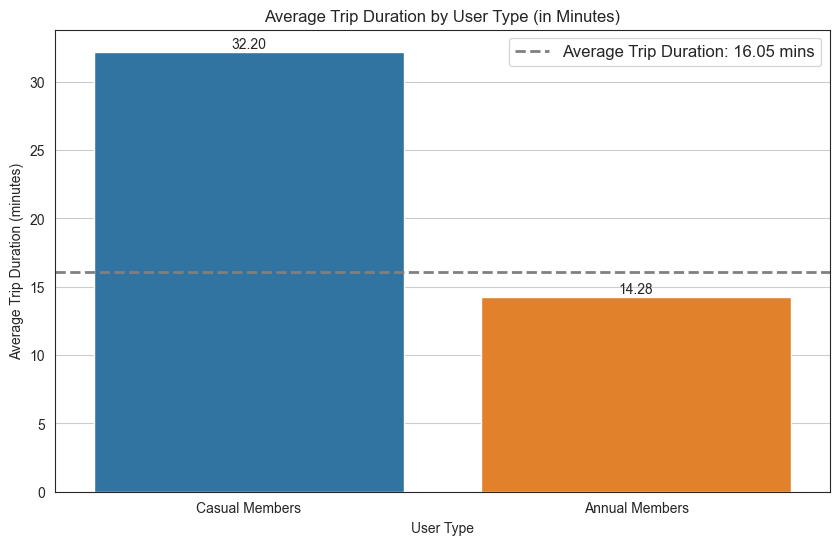

In [31]:
# Group by user type and statiojn names
grouped_stats = trips_df.groupby(['user_type', 'from_station_name'])['trip_duration_minutes'].mean().reset_index()

grouped_stats.rename(columns={'trip_duration_minutes':'Average Trip Duration (minutes)'}, inplace=True)
grouped_stats.sort_values(by='Average Trip Duration (minutes)', ascending=False, inplace=True)

average_trip_duration = round(trips_df["trip_duration_minutes"].sum()/trips_df.shape[0], 2)

plt.figure(figsize=(10, 6))
sns.set_style('white')

mean_trip_bars = sns.barplot(data=grouped_stats, x='user_type', y='Average Trip Duration (minutes)', hue='user_type', legend=False, errorbar=None)

# Adding data labels
for bar in mean_trip_bars.patches:
    height = bar.get_height()
    
    if height > 0:
        mean_trip_bars.annotate(
            f'{height:.2f}',  
            (bar.get_x() + bar.get_width() / 2., height),  
            ha='center', va='bottom'
        )

# Add a horizontal line to represent the overall total trip count
plt.axhline(
    average_trip_duration, # Overall average trip duration
    color='grey', 
    linestyle='dashed', 
    linewidth=2, 
    label=f'Average Trip Duration: {average_trip_duration} mins'
)

plt.xticks([0, 1], ['Casual Members', 'Annual Members'])
plt.title('Average Trip Duration by User Type (in Minutes)')
plt.ylabel('Average Trip Duration (minutes)')
plt.xlabel('User Type')
plt.legend(fontsize=12)
plt.grid(axis='y')
plt.show()

The significant difference in mean trip duration between casual members (32.2 minutes) and annual members (14.28 minutes) in your Toronto bikeshare dataset could be explained by several behavioral, usage, and membership characteristics typical of bikeshare systems:

1. **Casual Members Likely Use the Service for Leisure**
   - **Casual members** are often tourists, one-time users, or people who use the bikeshare service occasionally. They are more likely to ride bikes for leisure, sightseeing, or recreational purposes. These rides might last longer since they are not time-constrained like regular commuters.
   - They might also take more scenic routes, travel at a slower pace, and spend more time biking for enjoyment, which contributes to the higher average trip duration.

2. **Annual Members Are Often Commuters**
   - **Annual members** tend to use the service more regularly, often for practical purposes like commuting to work, school, or running errands. These trips are likely shorter and more optimized for time, as annual members may prefer a quick ride from point A to point B.
   - Regular usage as part of a daily routine (such as commuting) results in shorter, more predictable trip durations. Commuters might also use faster or more direct routes, decreasing their average trip time.

3. **Pricing Structure and Incentives**
   - Casual users might not be as concerned with the time limitations imposed by pricing structures. Many bikeshare programs charge per minute or per trip for casual users but offer unlimited trips up to a certain duration for annual members. For example, annual members might receive free rides under 30 minutes, which encourages them to keep their trips shorter to avoid extra fees.
   - **Casual members**, on the other hand, might be less aware of these pricing incentives or be willing to pay extra for longer trips since they are infrequent users.

4. **Travel Distance and Frequency of Use**
   - Annual members tend to take shorter but more frequent trips, while casual users might take fewer but longer trips. Casual users could be traveling greater distances or making fewer stops along their route compared to annual members, which can result in a higher average trip duration.

5. **Purpose of Travel**
   - The purpose of travel differs between the two groups. **Annual members** are likely riding for practical reasons, like commuting, where efficiency and shorter trip durations are key. **Casual members**, on the other hand, might be using the bikes for leisurely exploration or weekend outings, leading to longer trip durations.

## Visualize trip duration distribution using histograms to detect outliers and do binning.

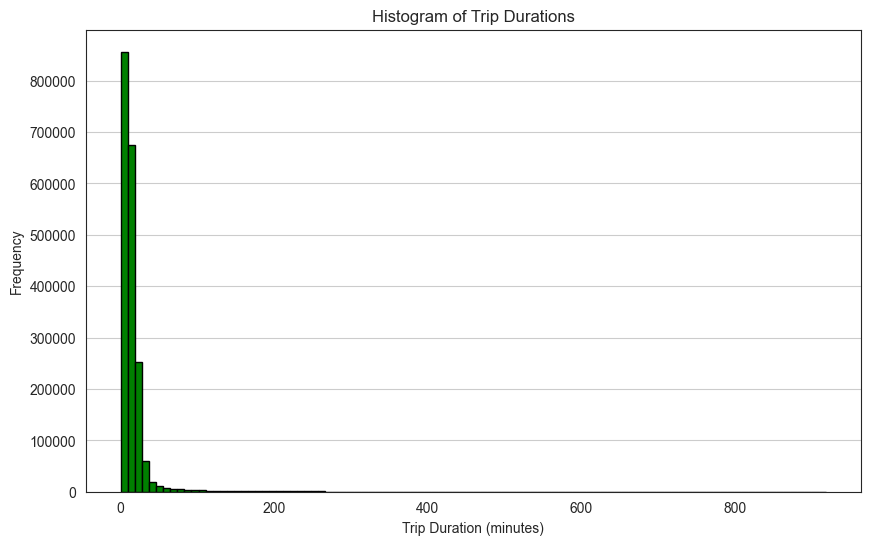

In [32]:
# Create a histogram using pandas plot
plt.figure(figsize=(10, 6))
trips_df['trip_duration_minutes'].plot(kind='hist', bins=100, color='green', edgecolor='black')

plt.title('Histogram of Trip Durations')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

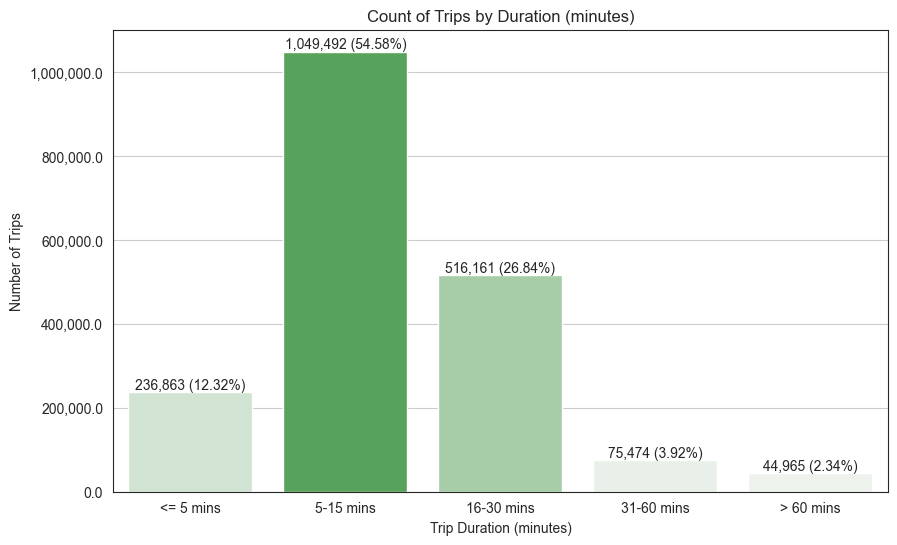

In [33]:
count_less_5     =  trips_df[trips_df['trip_duration_minutes']  <= 5].shape[0]
count_btw_6_15   =  trips_df[(trips_df['trip_duration_minutes'] > 5)  & (trips_df['trip_duration_minutes'] <= 15)].shape[0]
count_btw_16_30  =  trips_df[(trips_df['trip_duration_minutes'] > 15) & (trips_df['trip_duration_minutes'] <= 30)].shape[0]
count_btw_31_60  =  trips_df[(trips_df['trip_duration_minutes'] > 30) & (trips_df['trip_duration_minutes'] <= 60)].shape[0]
count_more_60    =  trips_df[trips_df['trip_duration_minutes']  > 60].shape[0]

# Creating a Dataframe with the trip duration counts and labels to plot it using seaborn
trip_counts_df = pd.DataFrame({
    'Trip Duration (minutes)': ['<= 5 mins', '5-15 mins', '16-30 mins', '31-60 mins', '> 60 mins'],
    'Number of Trips': [count_less_5, count_btw_6_15, count_btw_16_30, count_btw_31_60, count_more_60]
})

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Trip Duration (minutes)', y='Number of Trips', data=trip_counts_df, palette="light:"+green_color, hue='Number of Trips', legend=False)

# Add the text labels on top of the bars
for bar in bars.patches:
    height = bar.get_height()
    pct_height = height/trips_df.shape[0]*100
    bars.text(bar.get_x() + bar.get_width() / 2, height, f'{height:,.0f} ({pct_height:,.2f}%)', ha='center', va='bottom')

# Set y-axis labels to full numbers
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter(('{x:,.1f}')))
plt.title('Count of Trips by Duration (minutes)')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Trips')
plt.grid(axis='y')
plt.show()

## One minute trips analysis.

**User Behavior Understanding:**
Bike Rentals and Returns: If the dataset involves bike-sharing, this analysis could highlight user behaviors such as returning a bike immediately or using it briefly for an errand (e.g., adjusting a bike, checking a lock, or simply moving the bike). Understanding these behaviors can help improve service and user experience.

**Policy Development:**
Understanding Usage Trends: The data can inform policies related to bike-sharing, such as setting minimum rental times or implementing charges for short trips to encourage longer usage, which can increase overall revenue and utilization.

**Marketing Strategies:**
Targeted Promotions: If many users are making short trips, it may be worthwhile to develop marketing strategies aimed at encouraging longer rentals, such as offering discounts for trips longer than a certain duration.

**Service Improvements:**
User Feedback Loop: If a significant percentage of trips fall into this category, it may prompt further user feedback collection to understand why users are making such quick trips. It can lead to service modifications or additional user education.

In [34]:
one_minute_trip_df = trips_df[trips_df['trip_duration_minutes'] == 1]
one_minute_trip_df.shape[0]

145

In [35]:
round_trip_one_minute_df = trips_df[(trips_df['from_station_id'] == trips_df['to_station_id']) & (trips_df["trip_duration_minutes"] == 1)]
round_trip_one_minute_df.head(5)

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type,from_lat,from_lon,to_lat,to_lon,trip_start_hour,trip_start_day_of_week,trip_start_month,is_weekend,trip_time_category,trip_duration_minutes
3337,2388134,60,7164,2018-01-04 18:04:00,Gould St / Yonge St (Ryerson University),2018-01-04 18:05:00,7164,Gould St / Yonge St (Ryerson University),1,43.657424,-79.381019,43.657424,-79.381019,18,Thursday,January,No,evening_rush,1.0
17001,2407016,60,7120,2018-01-17 09:55:00,Gerrard St E / River St,2018-01-17 09:56:00,7120,Gerrard St E / River St,1,43.663993,-79.358534,43.663993,-79.358534,9,Wednesday,January,No,morning_rush,1.0
32069,2427814,60,7271,2018-01-25 11:16:00,Yonge St / Alexander St - SMART,2018-01-25 11:17:00,7271,Yonge St / Alexander St - SMART,1,43.662862,-79.383572,43.662862,-79.383572,11,Thursday,January,No,off_peak,1.0
13240,2400719,60,7039,2018-01-14 11:05:00,Simcoe St / Michael Sweet Ave,2018-01-14 11:06:00,7039,Simcoe St / Michael Sweet Ave,1,43.652327,-79.388254,43.652327,-79.388254,11,Sunday,January,Yes,off_peak,1.0
71924,2478080,60,7132,2018-02-21 09:50:00,Kendal Ave / Spadina Rd,2018-02-21 09:51:00,7132,Kendal Ave / Spadina Rd,1,43.670318,-79.405181,43.670318,-79.405181,9,Wednesday,February,No,morning_rush,1.0


In [36]:
print("Number of round trips done within a minute:", round_trip_one_minute_df.shape[0])

Number of round trips done within a minute: 120


In [37]:
# Create a Folium map centered around the average location of the stations
map_center = [round_trip_one_minute_df['from_lat'].mean(), round_trip_one_minute_df['from_lon'].mean()]
station_map = folium.Map(location=map_center, zoom_start=13)

# Iterate over the DataFrame and add markers for start and end stations
for index, row in round_trip_one_minute_df.iterrows():
    # Assign a color for the trip (you can cycle through the color list)
    trip_color = get_random_predefined_color()
    
    # Add a marker for the start station
    folium.Marker(
        location=[row['from_lat'], row['from_lon']],
        popup=row['from_station_name'],
        icon=folium.Icon(color=trip_color, icon='bicycle', prefix='fa')
    ).add_to(station_map)

station_map

In [38]:
one_way_one_minute_trip_df = trips_df[(trips_df['from_station_id'] != trips_df['to_station_id']) & (trips_df["trip_duration_minutes"] == 1)]

In [39]:
print("Count of one way trips done within a minute:", one_way_one_minute_trip_df.shape[0])

Count of one way trips done within a minute: 25


In [40]:
# Create a Folium map centered around the average location of the stations
map_center = [one_way_one_minute_trip_df['from_lat'].mean(), one_way_one_minute_trip_df['from_lon'].mean()]
station_map = folium.Map(location=map_center, zoom_start=13)

# Color list for unique trip visualization
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 
          'beige', 'darkblue', 'darkgreen', 'cadetblue', 'pink']

# Iterate over the DataFrame and add markers for start and end stations
for index, row in one_way_one_minute_trip_df.iterrows():
    # Assign a color for the trip (you can cycle through the color list)
    trip_color = colors[index % len(colors)]
    
    # Add a marker for the start station with an auto-open popup
    folium.Marker(
        location=[row['from_lat'], row['from_lon']],
        icon=folium.Icon(color=trip_color, icon='bicycle', prefix='fa'),
        popup=folium.Popup(row['from_station_name'], auto_open=True, max_width=500)
    ).add_to(station_map)
    
    # Add a marker for the end station with an auto-open popup
    folium.Marker(
        location=[row['to_lat'], row['to_lon']],
        icon=folium.Icon(color=trip_color, icon='stop'),
        popup=folium.Popup(row['to_station_name'], auto_open=True, max_width=500)
    ).add_to(station_map)
    
    # Draw a line between the start and end stations
    folium.PolyLine(
        locations=[(row['from_lat'], row['from_lon']), (row['to_lat'], row['to_lon'])],
        color=trip_color,
        weight=2.5,
        opacity=1
    ).add_to(station_map)

station_map


## Time-Based Analysis: Use groupby to analyze trip duration by hour of the day, day of the week, or month.

### Count of Trips

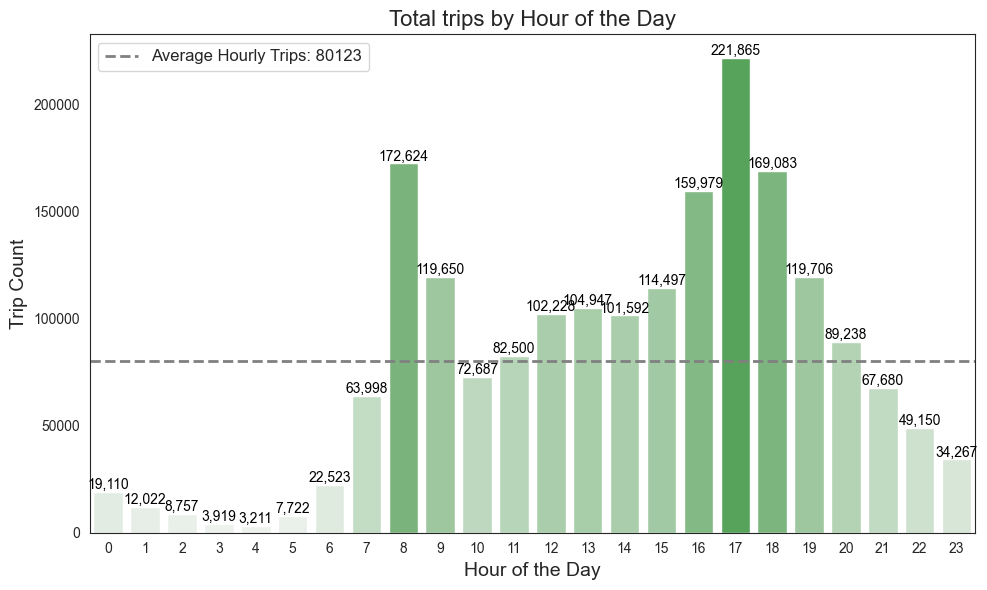

In [41]:
hourly_trip_count = trips_df.groupby('trip_start_hour').size().reset_index(name='trip_count')

total_trip_count = trips_df.shape[0]

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='trip_start_hour', y='trip_count', data=hourly_trip_count, palette="light:"+green_color, hue='trip_count', legend=False)

# Annotate bars with the trip count
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height):,}', 
             ha='center', va='bottom', fontsize=10, color='black')

# Set plot title and labels
plt.title('Total trips by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Trip Count', fontsize=14)
plt.xticks(rotation=0)  # Keep hour labels without rotation

# Add a horizontal line to represent the overall total trip count
plt.axhline(
    total_trip_count / 24, # Overall Hourly average trips
    color='grey', 
    linestyle='dashed', 
    linewidth=2, 
    label=f'Average Hourly Trips: {total_trip_count // 24}'
)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\mohit\AppData\Local\Temp\ipykernel_9636\1171696185.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_trip_count = trips_df.groupby('trip_start_day_of_week').size().reset_index(name='trip_count')


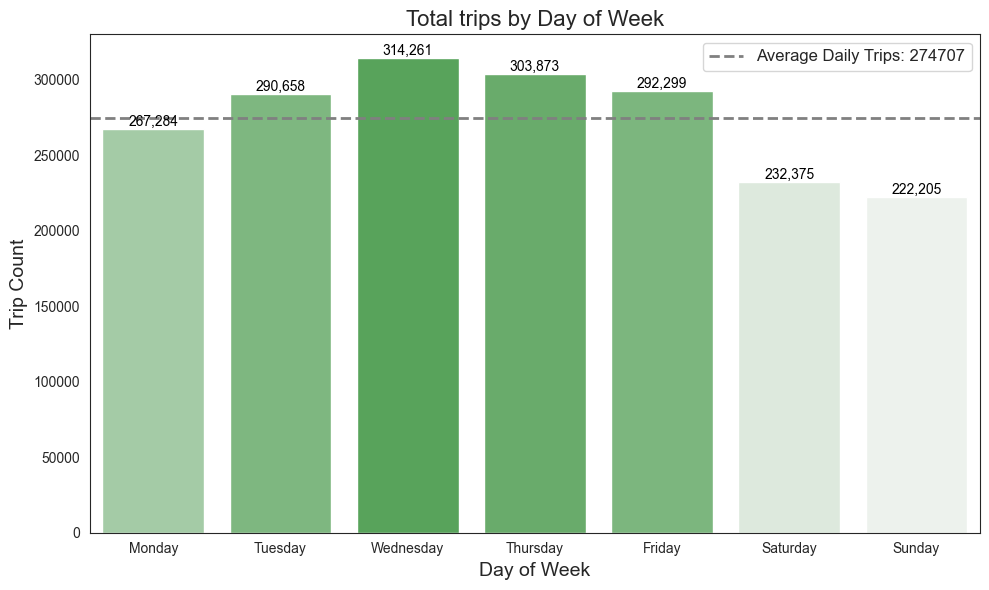

In [42]:
weekday_trip_count = trips_df.groupby('trip_start_day_of_week').size().reset_index(name='trip_count')

total_trip_count = trips_df.shape[0]

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='trip_start_day_of_week', y='trip_count', data=weekday_trip_count, palette="light:"+green_color, hue='trip_count', legend=False)

# Annotate bars with the trip count
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height):,}', 
             ha='center', va='bottom', fontsize=10, color='black')

# Set plot title and labels
plt.title('Total trips by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Trip Count', fontsize=14)
plt.xticks(rotation=0)  # Keep hour labels without rotation

# Add a horizontal line to represent the overall total trip count
plt.axhline(
    total_trip_count / 7, # Overall Hourly average trips
    color='grey', 
    linestyle='dashed', 
    linewidth=2, 
    label=f'Average Daily Trips: {total_trip_count // 7}'
)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\mohit\AppData\Local\Temp\ipykernel_9636\1329251816.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_trip_count = trips_df.groupby('trip_start_month').size().reset_index(name='trip_count')


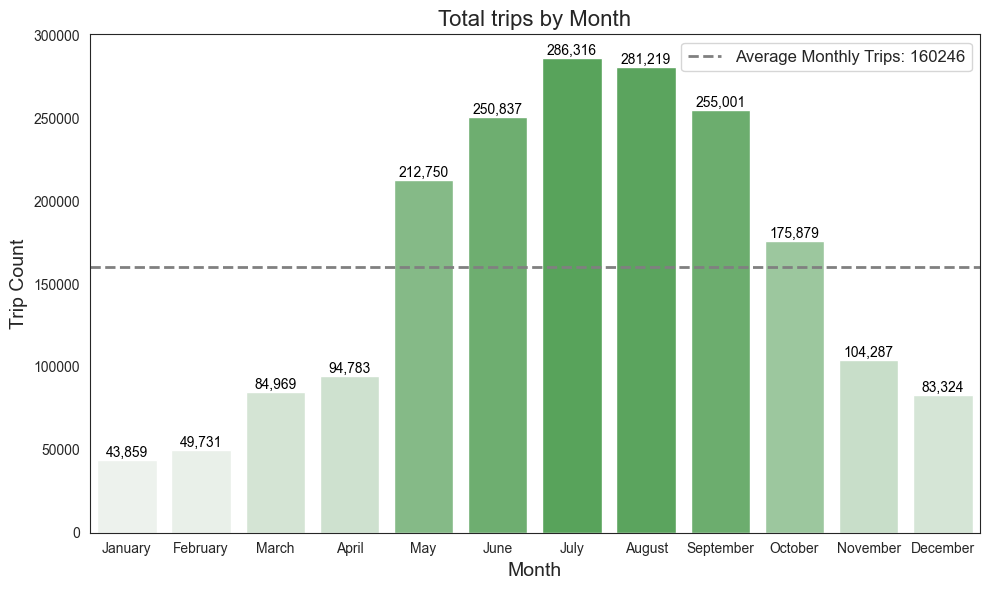

In [43]:
monthly_trip_count = trips_df.groupby('trip_start_month').size().reset_index(name='trip_count')

total_trip_count = trips_df.shape[0]

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='trip_start_month', y='trip_count', data=monthly_trip_count, palette="light:"+green_color, hue='trip_count', legend=False)

# Annotate bars with the trip count
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height):,}', 
             ha='center', va='bottom', fontsize=10, color='black')

# Set plot title and labels
plt.title('Total trips by Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Trip Count', fontsize=14)
plt.xticks(rotation=0)  # Keep hour labels without rotation

# Add a horizontal line to represent the overall total trip count
plt.axhline(
    total_trip_count / 12, # Overall Hourly average trips
    color='grey', 
    linestyle='dashed', 
    linewidth=2, 
    label=f'Average Monthly Trips: {total_trip_count // 12}'
)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Average trip duration

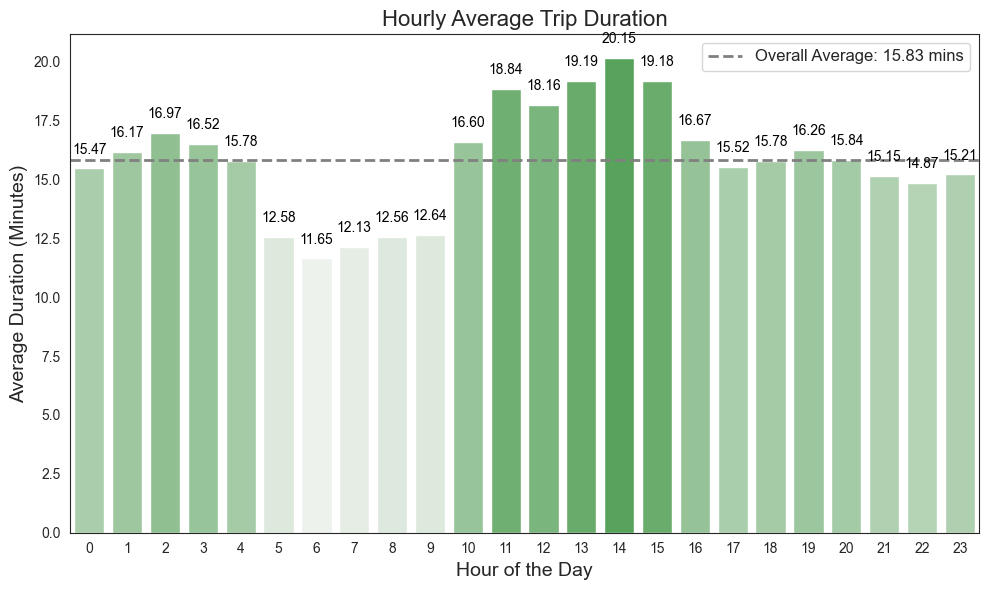

In [44]:
# Calculate hourly average trip duration
hourly_duration_new = trips_df.groupby('trip_start_hour')['trip_duration_minutes'].mean().reset_index()

# Calculate overall average trip duration
overall_average_hourly = hourly_duration_new['trip_duration_minutes'].mean().round(2)

# Create the barplot
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x='trip_start_hour', 
    y='trip_duration_minutes', 
    data=hourly_duration_new, 
    palette="light:"+green_color,
    hue='trip_duration_minutes',
    legend=False
)

# Annotate the bars with their respective heights (average duration)
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.5, 
        f'{height:.2f}', 
        ha='center', va='bottom', fontsize=10, color='black'
    )

# Set titles and labels
plt.title('Hourly Average Trip Duration', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Average Duration (Minutes)', fontsize=14)
plt.xticks(rotation=0)  # No rotation for hour labels

# Add a horizontal line for the overall average trip duration
plt.axhline(
    overall_average_hourly, 
    color='grey', 
    linestyle='--', 
    linewidth=2, 
    label=f'Overall Average: {overall_average_hourly} mins'
)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\mohit\AppData\Local\Temp\ipykernel_9636\123051280.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_of_week_duration_new = trips_df.groupby('trip_start_day_of_week')['trip_duration_minutes'].mean().reset_index()


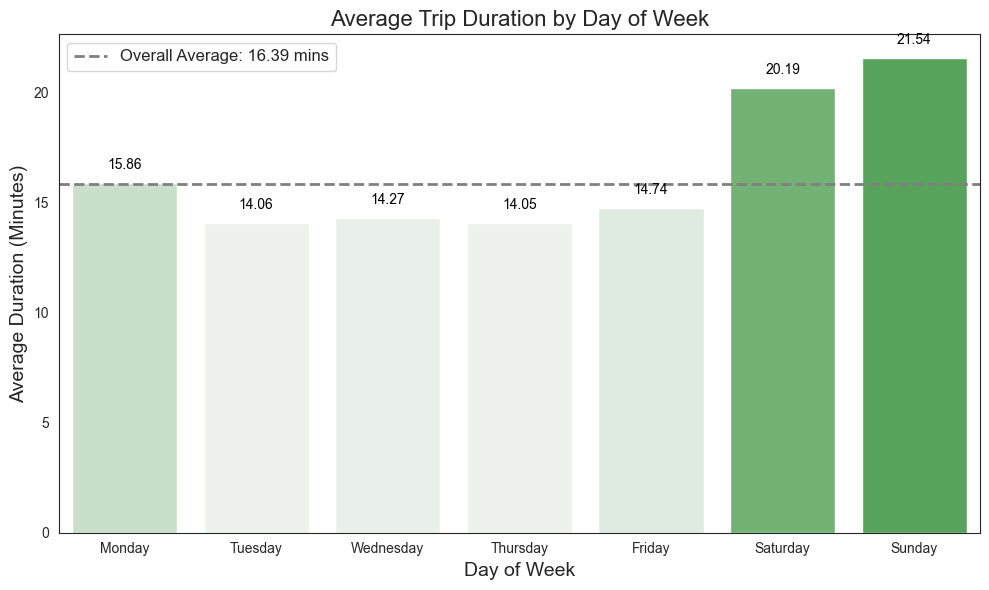

In [45]:
# Calculate average trip duration of day of week
day_of_week_duration_new = trips_df.groupby('trip_start_day_of_week')['trip_duration_minutes'].mean().reset_index()

# Calculate overall average trip duration
overall_average_weekly = day_of_week_duration_new['trip_duration_minutes'].mean().round(2)

# Create the barplot
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x='trip_start_day_of_week', 
    y='trip_duration_minutes', 
    data=day_of_week_duration_new, 
    palette="light:"+green_color,
    hue='trip_duration_minutes',
    legend=False
)

# Annotate the bars with their respective heights (average duration)
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.5, 
        f'{height:.2f}', 
        ha='center', va='bottom', fontsize=10, color='black'
    )

# Set titles and labels
plt.title('Average Trip Duration by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Average Duration (Minutes)', fontsize=14)
plt.xticks(rotation=0)

# Add a horizontal line for the overall average trip duration
plt.axhline(
    overall_average_hourly, 
    color='grey', 
    linestyle='--', 
    linewidth=2, 
    label=f'Overall Average: {overall_average_weekly} mins'
)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\mohit\AppData\Local\Temp\ipykernel_9636\2871371679.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_duration_new = trips_df.groupby('trip_start_month')['trip_duration_minutes'].mean().reset_index()


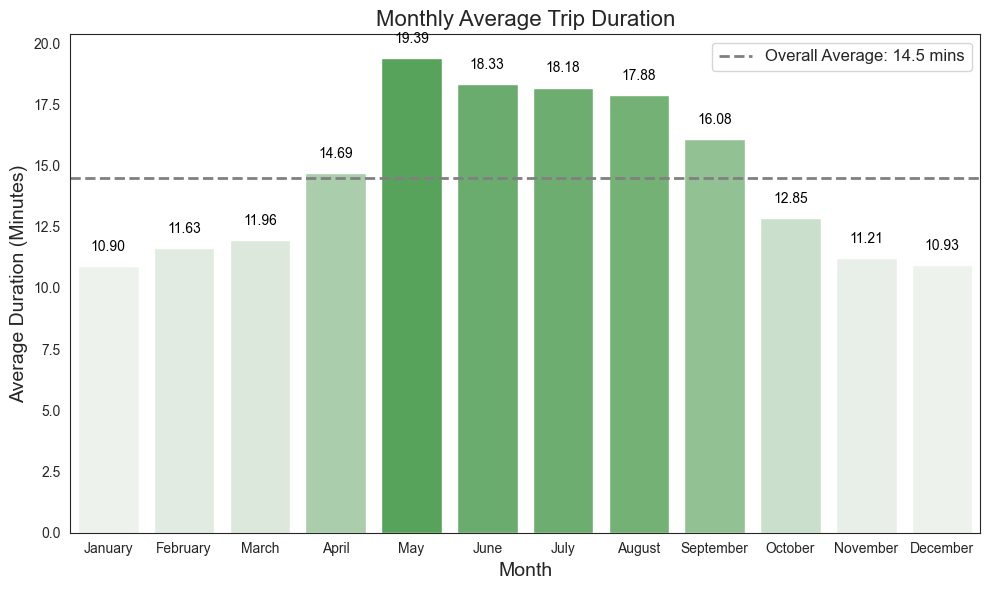

In [46]:
# Calculate average trip duration of day of week
monthly_duration_new = trips_df.groupby('trip_start_month')['trip_duration_minutes'].mean().reset_index()

# Calculate overall average trip duration
overall_average_monthly = monthly_duration_new['trip_duration_minutes'].mean().round(2)

# Create the barplot
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    x='trip_start_month', 
    y='trip_duration_minutes', 
    data=monthly_duration_new, 
    palette="light:"+green_color,
    hue='trip_duration_minutes',
    legend=False
)

# Annotate the bars with their respective heights (average duration)
for bar in bars.patches:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height + 0.5, 
        f'{height:.2f}', 
        ha='center', va='bottom', fontsize=10, color='black'
    )

# Set titles and labels
plt.title('Monthly Average Trip Duration', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Average Duration (Minutes)', fontsize=14)
plt.xticks(rotation=0)

# Add a horizontal line for the overall average trip duration
plt.axhline(
    overall_average_monthly, 
    color='grey', 
    linestyle='--', 
    linewidth=2, 
    label=f'Overall Average: {overall_average_monthly} mins'
)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 2. Station Popularity and Demand

## Top 10 Starting demanding stations

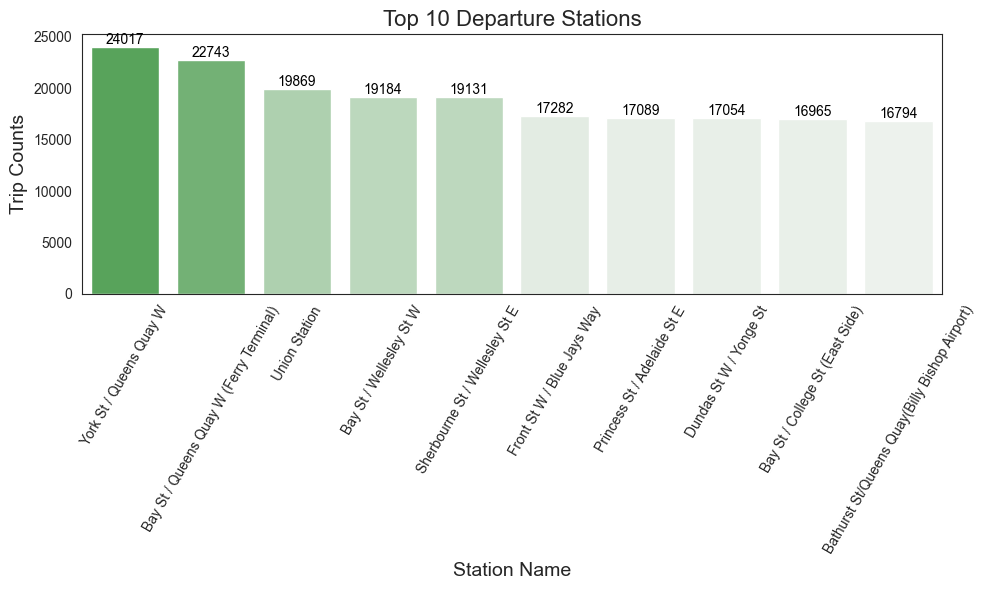

In [78]:
# Count trips starting from each station
demand_start = trips_df['from_station_name'].value_counts().reset_index()
demand_start.columns = ['station', 'total_trips']
demand_start = demand_start.head(10)

plt.figure(figsize=(10, 6))
sns.set_style('white')

bars = sns.barplot(x='station', y='total_trips', data=demand_start, palette="light:"+green_color, hue='total_trips', legend=False)

# Annotate bars with the average duration data labels
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, int(height), ha='center', va='bottom', fontsize=10, color='black')

# Set titles and labels
plt.title('Top 10 Departure Stations', fontsize=16)
plt.xlabel('Station Name', fontsize=14)
plt.ylabel('Trip Counts', fontsize=14)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

## Top 10 Ending demanding stations

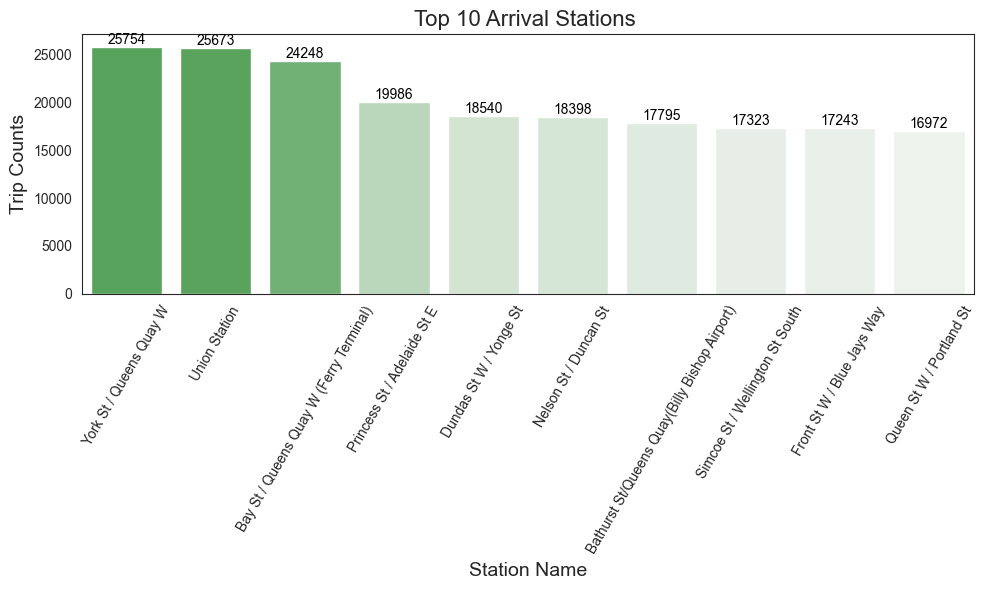

In [93]:
# Count trips ending at each station
demand_end = trips_df['to_station_name'].value_counts().reset_index()
demand_end.columns = ['station', 'total_trips']
demand_end = demand_end.head(10)

plt.figure(figsize=(10, 6))
sns.set_style('white')

bars = sns.barplot(x='station', y='total_trips', data=demand_end, palette="light:"+green_color, hue='total_trips', legend=False)

# Annotate bars with the average duration data labels
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, int(height), ha='center', va='bottom', fontsize=10, color='black')

# Set titles and labels
plt.title('Top 10 Arrival Stations ', fontsize=16)
plt.xlabel('Station Name', fontsize=14)
plt.ylabel('Trip Counts', fontsize=14)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


## Plot Top Departure and Arrival Stations on Map

In [ ]:
# Merge top 10 stations with station location data from trips_df to get latitude and longitude
top_10_locations_departure = trips_df[trips_df['from_station_name'].isin(demand_start['station'])][['from_station_name', 'from_lat', 'from_lon']].drop_duplicates()

# Merge total_trips from demand_start into the top_10_locations_departure DataFrame
top_10_locations_departure = top_10_locations_departure.merge(demand_start[['station', 'total_trips']], left_on='from_station_name', right_on='station', how='left')

# Merge top 10 stations with station location data from trips_df to get latitude and longitude
top_10_locations_arrival = trips_df[trips_df['from_station_name'].isin(demand_end['station'])][['from_station_name', 'from_lat', 'from_lon']].drop_duplicates()

# Merge total_trips from demand_end into the top_10_locations_arrival DataFrame
top_10_locations_arrival = top_10_locations_arrival.merge(demand_end[['station', 'total_trips']], left_on='from_station_name', right_on='station', how='left')


# Create a base map centered at the mean latitude and longitude of the top 10 stations
map_center = [
    (top_10_locations_arrival['from_lat'].head(10).mean() + top_10_locations_departure['from_lat'].head(10).mean()) / 2, 
    (top_10_locations_arrival['from_lon'].head(10).mean() + top_10_locations_departure['from_lon'].head(10).mean()) / 2
]


station_map = folium.Map(location=map_center, zoom_start=13)

# Create MarkerCluster object to cluster arrival and departure stations and to avoid markers to overlap
station_map_clustered = MarkerCluster().add_to(station_map)


# Plot departure stations with a green color
for index, row in top_10_locations_departure.iterrows():
    if pd.notna(row['from_lat']) and pd.notna(row['from_lon']):  # Check if lat/lon values are valid
        icon_color = 'green'
        
        folium.Marker(
            location=[row['from_lat'], row['from_lon']],
            icon=folium.Icon(color=icon_color, icon="bicycle", prefix='fa'),
            popup=folium.Popup(f"""
                <div style="width: 300px; padding: 10px; font-size: 14px;">
                    <strong>Category:</strong> Departure Station<br><br>
                    <strong>Rank:</strong> {str(index+1)}<br><br>
                    <strong>Name:</strong> {row['from_station_name']}<br><br>
                    <strong>Total Trips:</strong> {row['total_trips']}
                </div>
                """, max_width=300)
        ).add_to(station_map_clustered)

# Plot arrival stations with red color
for index, row in top_10_locations_arrival.iterrows():
    if pd.notna(row['from_lat']) and pd.notna(row['from_lon']):  # Check if lat/lon values are valid
        icon_color = 'red'
        
        folium.Marker(
            location=[row['from_lat'], row['from_lon']],
            icon=folium.Icon(color=icon_color, icon="bicycle", prefix='fa'),
            popup=folium.Popup(f"""
                <div style="width: 300px; padding: 10px; font-size: 14px;">
                    <strong>Category:</strong> Arrival Station<br><br>
                    <strong>Rank:</strong> {str(index+1)}<br><br>
                    <strong>Name:</strong> {row['from_station_name']}<br><br>
                    <strong>Total Trips:</strong> {row['total_trips']}
                </div>
                """, max_width=300)
        ).add_to(station_map_clustered)

# Display the map
station_map

## Station Pair Frequency: Analyze station pairs to see which routes are most frequently used.

In [118]:
# Make a pair of start and to stations
trips_df["station_pair"] = list(zip(trips_df['from_station_name'], trips_df['to_station_name']))

# Count pairs
station_pairs = trips_df.groupby('station_pair').size().reset_index(name='trip_count').sort_values(by='trip_count', ascending=False)

# Convert the tuples in 'station_pair' to strings
station_pairs['station_pair_label'] = station_pairs['station_pair'].apply(lambda x: ' - '.join(x))

# Extract the start and end stations from the tuples
station_pairs[['start_station', 'end_station']] = pd.DataFrame(station_pairs['station_pair'].tolist(), index=station_pairs.index)

station_pair_count = station_pairs.shape[0]
station_pair_count

83197

In [119]:
station_pairs.head(5)

,station_pair,trip_count,station_pair_label,start_station,end_station
7948,"(Bay St / Queens Quay W (Ferry Terminal), Bay ...",3515,Bay St / Queens Quay W (Ferry Terminal) - Bay ...,Bay St / Queens Quay W (Ferry Terminal),Bay St / Queens Quay W (Ferry Terminal)
38110,"(Humber Bay Shores Park West, Humber Bay Shore...",2162,Humber Bay Shores Park West - Humber Bay Shore...,Humber Bay Shores Park West,Humber Bay Shores Park West
83196,"(York St / Queens Quay W, York St / Queens Qua...",1969,York St / Queens Quay W - York St / Queens Quay W,York St / Queens Quay W,York St / Queens Quay W
6171,(Bathurst St/Queens Quay(Billy Bishop Airport)...,1964,Bathurst St/Queens Quay(Billy Bishop Airport) ...,Bathurst St/Queens Quay(Billy Bishop Airport),York St / Queens Quay W
32139,"(Front St W / Blue Jays Way, Union Station)",1955,Front St W / Blue Jays Way - Union Station,Front St W / Blue Jays Way,Union Station


Total all possible Combinations of stations

In [120]:
total_stations   = trips_df["to_station_id"].value_counts().count()
all_combinations = int(math.factorial(total_stations)/math.factorial(total_stations-2))

There are total 128,522 possible station pairs.

There are total 83,197 pairs of unique station pairs in the dataset.

In [121]:
top_station_pairs = station_pairs.head(10).reset_index(drop=True)

top_station_pairs

,station_pair,trip_count,station_pair_label,start_station,end_station
0,"(Bay St / Queens Quay W (Ferry Terminal), Bay ...",3515,Bay St / Queens Quay W (Ferry Terminal) - Bay ...,Bay St / Queens Quay W (Ferry Terminal),Bay St / Queens Quay W (Ferry Terminal)
1,"(Humber Bay Shores Park West, Humber Bay Shore...",2162,Humber Bay Shores Park West - Humber Bay Shore...,Humber Bay Shores Park West,Humber Bay Shores Park West
2,"(York St / Queens Quay W, York St / Queens Qua...",1969,York St / Queens Quay W - York St / Queens Quay W,York St / Queens Quay W,York St / Queens Quay W
3,(Bathurst St/Queens Quay(Billy Bishop Airport)...,1964,Bathurst St/Queens Quay(Billy Bishop Airport) ...,Bathurst St/Queens Quay(Billy Bishop Airport),York St / Queens Quay W
4,"(Front St W / Blue Jays Way, Union Station)",1955,Front St W / Blue Jays Way - Union Station,Front St W / Blue Jays Way,Union Station
5,"(Ontario Place Blvd / Lakeshore Blvd W, Ontari...",1746,Ontario Place Blvd / Lakeshore Blvd W - Ontari...,Ontario Place Blvd / Lakeshore Blvd W,Ontario Place Blvd / Lakeshore Blvd W
6,"(Tommy Thompson Park (Leslie Street Spit), Tom...",1742,Tommy Thompson Park (Leslie Street Spit) - Tom...,Tommy Thompson Park (Leslie Street Spit),Tommy Thompson Park (Leslie Street Spit)
7,"(York St / Queens Quay W, Bathurst St/Queens Q...",1617,York St / Queens Quay W - Bathurst St/Queens Q...,York St / Queens Quay W,Bathurst St/Queens Quay(Billy Bishop Airport)
8,"(HTO Park (Queens Quay W), HTO Park (Queens Qu...",1606,HTO Park (Queens Quay W) - HTO Park (Queens Qu...,HTO Park (Queens Quay W),HTO Park (Queens Quay W)
9,"(Lakeshore Blvd W / Ellis Ave, Lakeshore Blvd ...",1562,Lakeshore Blvd W / Ellis Ave - Lakeshore Blvd ...,Lakeshore Blvd W / Ellis Ave,Lakeshore Blvd W / Ellis Ave


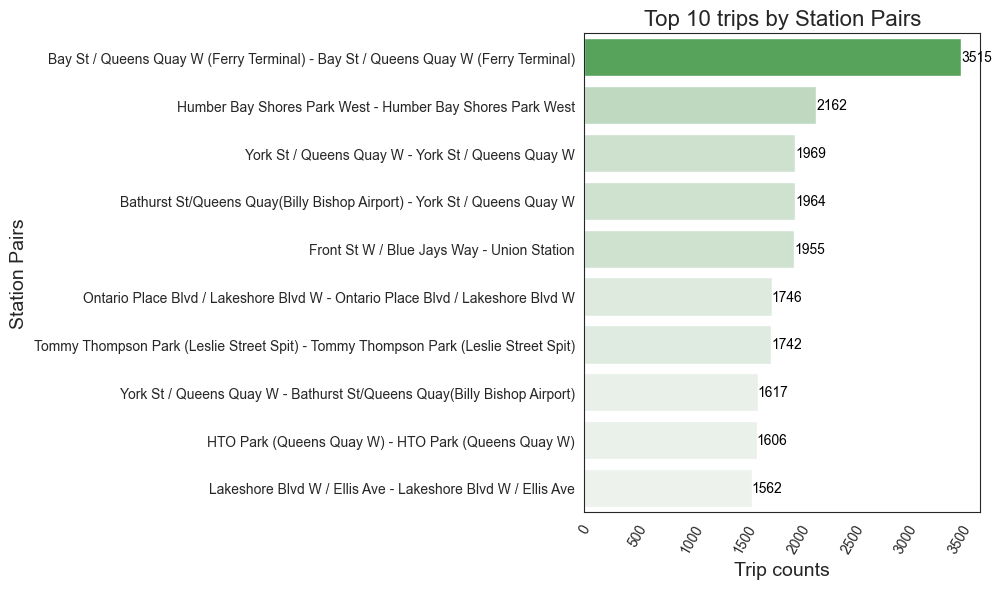

In [122]:
plt.figure(figsize=(10, 6))
sns.set_style('white')

bars = sns.barplot(x='trip_count', y='station_pair_label', data=top_station_pairs, palette="light:"+green_color, hue='trip_count', legend=False)

# Annotate bars with the average duration data labels
for bar in bars.patches:
    width = bar.get_width()  # Since bars are horizontal, we will use the width
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, int(width), ha='left', va='center', fontsize=10, color='black')

# Set titles and labels
plt.title('Top 10 trips by Station Pairs', fontsize=16)
plt.xlabel('Trip counts', fontsize=14)
plt.ylabel('Station Pairs', fontsize=14)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

## Plot Top 10 Station pairs by Total trips

In [131]:
# Pending

## Station Usage Trends: Analyze the usage of stations based on time (morning/evening rush, weekends vs. weekdays).

In [ ]:
trips_df['is_weekend'] = trips_df['trip_start_day_of_week'].apply(lambda x: 'Yes' if x in ['Saturday', 'Sunday'] else 'No')

def categorize_time(hour):
    if 7 <= hour <= 9:
        return 'morning_rush'
    elif 17 <= hour <= 19:
        return 'evening_rush'
    else:
        return 'off_peak'

trips_df['trip_time_category'] = trips_df['trip_start_hour'].apply(categorize_time)
trips_df.head(3)

,trip_id,trip_duration_seconds,from_station_id,trip_start_time,from_station_name,trip_stop_time,to_station_id,to_station_name,user_type,from_lat,from_lon,to_lat,to_lon,trip_start_hour,trip_start_day_of_week,trip_start_month,is_weekend,trip_time_category,trip_duration_minutes,station_pair
0,2383648,393,7018,2018-01-01 00:47:00,Bremner Blvd / Rees St,2018-01-01 00:54:00,7176,Bathurst St / Fort York Blvd,1,43.641529,-79.386741,43.639179,-79.399595,0,Monday,January,No,off_peak,6.55,"(Bremner Blvd / Rees St, Bathurst St / Fort Yo..."
22944,2416605,1126,7248,2018-01-20 14:59:00,Baldwin Ave / Spadina Ave - SMART,2018-01-20 15:17:00,7016,Bay St / Queens Quay W (Ferry Terminal),1,43.654905,-79.398448,43.640978,-79.376785,14,Saturday,January,Yes,off_peak,18.77,"(Baldwin Ave / Spadina Ave - SMART, Bay St / Q..."
22943,2416603,101,7164,2018-01-20 14:58:00,Gould St / Yonge St (Ryerson University),2018-01-20 14:59:00,7028,Gould St / Mutual St,1,43.657424,-79.381019,43.658200,-79.376800,14,Saturday,January,Yes,off_peak,1.68,"(Gould St / Yonge St (Ryerson University), Gou..."


In [ ]:
# Group by station and time category
usage_trends_from_station = trips_df.groupby(['from_station_name', 'trip_time_category']).size().unstack(fill_value=0)

# Add a column for row totals
usage_trends_from_station['total_trips'] = usage_trends_from_station.sum(axis=1)

usage_trends_from_station["morning_rush_pct"] = round(usage_trends_from_station["morning_rush"]/usage_trends_from_station["total_trips"]*100, 2)
usage_trends_from_station["evening_rush_pct"] = round(usage_trends_from_station["evening_rush"]/usage_trends_from_station["total_trips"]*100, 2)
usage_trends_from_station["off_peak_pct"]     = round(100 - usage_trends_from_station["morning_rush_pct"] - usage_trends_from_station["evening_rush_pct"], 2)

usage_trends_from_station = usage_trends_from_station.sort_values("total_trips", ascending=False)
usage_trends_from_station.head(3)

trip_time_category,evening_rush,morning_rush,off_peak,total_trips,morning_rush_pct,evening_rush_pct,off_peak_pct
from_station_name,,,,,,,
York St / Queens Quay W,7757,2597,13663,24017,10.81,32.30,56.89
Bay St / Queens Quay W (Ferry Terminal),6652,2129,13962,22743,9.36,29.25,61.39
Union Station,4032,8012,7825,19869,40.32,20.29,39.39


In [ ]:
# Group by station and time category
usage_trends_to_station = trips_df.groupby(['to_station_name', 'trip_time_category']).size().unstack(fill_value=0)

# Add a column for row totals
usage_trends_to_station['total_trips'] = usage_trends_to_station.sum(axis=1)

usage_trends_to_station["morning_rush_pct"] = round(usage_trends_to_station["morning_rush"]/usage_trends_to_station["total_trips"]*100, 2)
usage_trends_to_station["evening_rush_pct"] = round(usage_trends_to_station["evening_rush"]/usage_trends_to_station["total_trips"]*100, 2)
usage_trends_to_station["off_peak_pct"]     = round(100 - usage_trends_to_station["morning_rush_pct"] - usage_trends_to_station["evening_rush_pct"], 2)

usage_trends_to_station = usage_trends_to_station.sort_values("total_trips", ascending=False)

### Distribution of all trips

Higher Whisker Value from Station: 16794.0


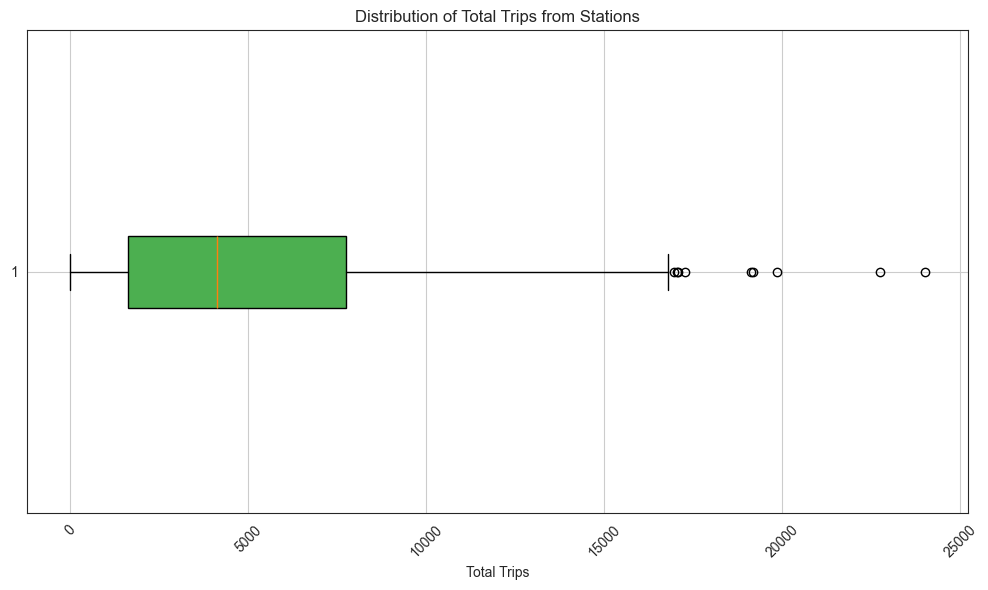

In [ ]:
plt.figure(figsize=(10, 6))
box = plt.boxplot(usage_trends_from_station["total_trips"], vert=False, patch_artist=True)

# Extract higher whisker value
higher_whisker_from_station = box['whiskers'][1].get_xdata()[1]

for patch in box['boxes']:
    patch.set_facecolor(green_color) 

# Print the higher whisker value
print("Higher Whisker Value from Station:", higher_whisker_from_station)

plt.xlabel('Total Trips')
plt.title('Distribution of Total Trips from Stations')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Top Stations

10


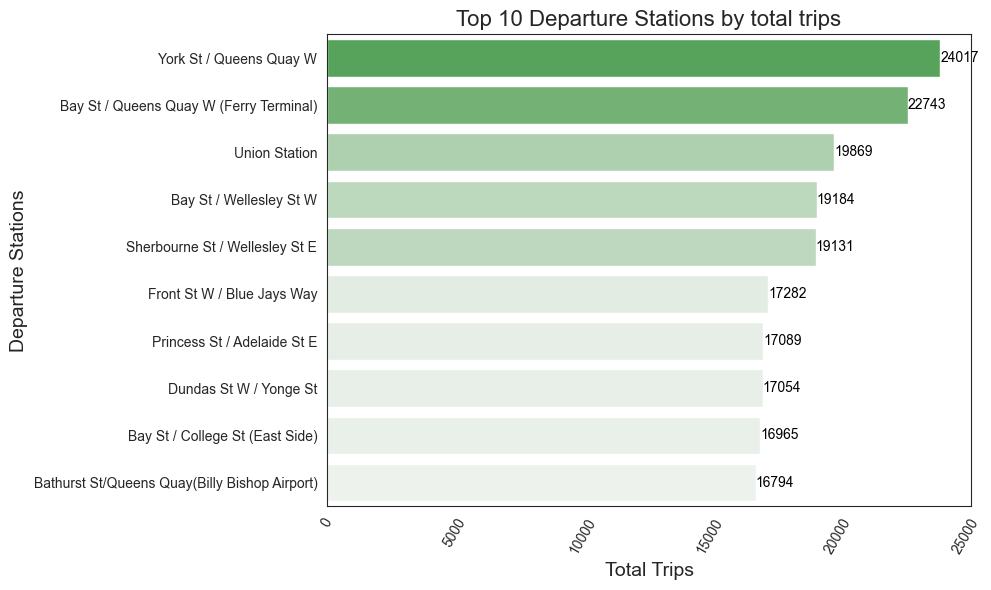

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style('white')

top_stations_data = usage_trends_from_station[usage_trends_from_station["total_trips"] >= higher_whisker_from_station]
print(top_stations_data.shape[0])
bars = sns.barplot(x='total_trips', y='from_station_name', data=top_stations_data, palette="light:"+green_color, hue='total_trips', legend=False)

# Annotate bars with the average duration data labels
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, int(width), ha='left', va='center', fontsize=10, color='black')

# Set titles and labels
plt.title('Top 10 Departure Stations by total trips', fontsize=16)
plt.xlabel('Total Trips', fontsize=14)
plt.ylabel('Departure Stations', fontsize=14)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

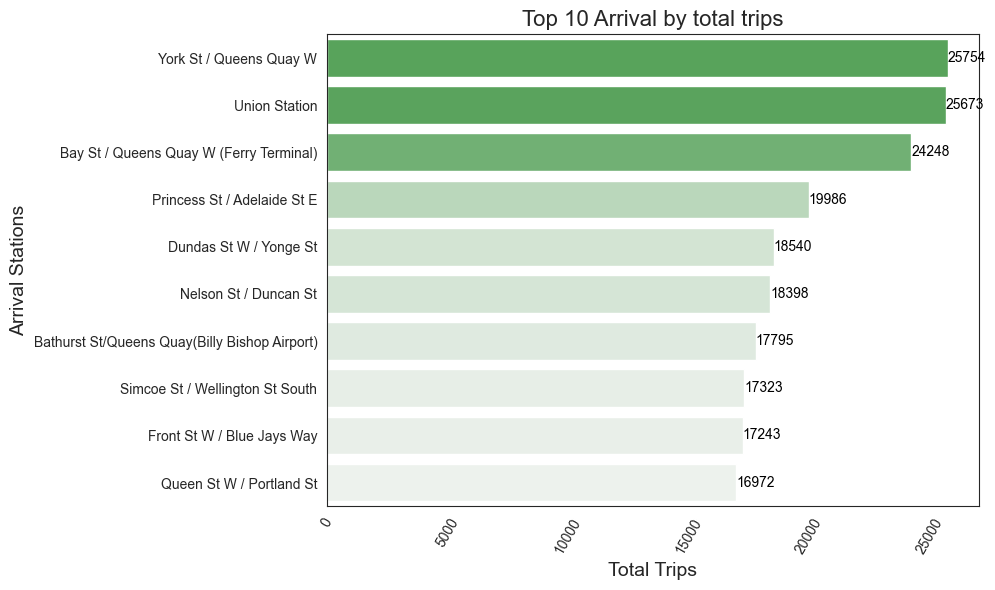

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style('white')

data = usage_trends_to_station.head(top_stations_data.shape[0])

bars = sns.barplot(x='total_trips', y='to_station_name', data=data, palette="light:"+green_color, hue='total_trips', legend=False)

# Annotate bars with the average duration data labels
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, int(width), ha='left', va='center', fontsize=10, color='black')

# Set titles and labels
plt.title('Top 10 Arrival by total trips', fontsize=16)
plt.xlabel('Total Trips', fontsize=14)
plt.ylabel('Arrival Stations', fontsize=14)
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

### By Morning and Evening rush

Overall distribution of trips by Rush category

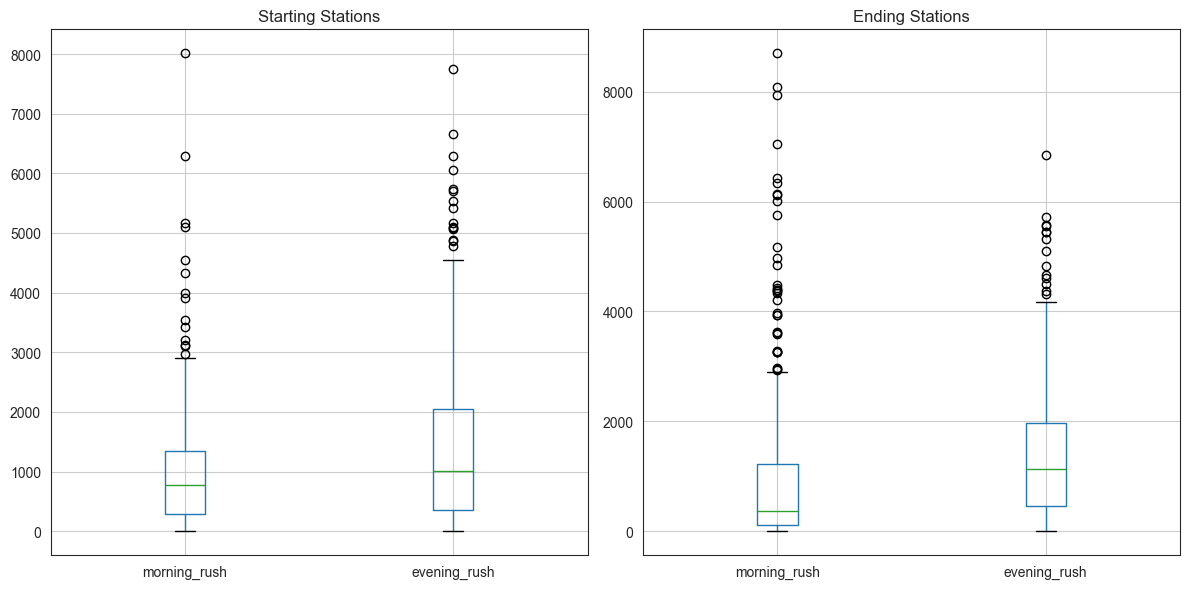

In [ ]:
# Created subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot boxplot for 'usage_trends_from_station'
usage_trends_from_station[["morning_rush", "evening_rush"]].boxplot(ax=axes[0])
axes[0].set_title('Starting Stations')

# Plot boxplot for 'usage_trends_to_station'
usage_trends_to_station[["morning_rush", "evening_rush"]].boxplot(ax=axes[1])
axes[1].set_title('Ending Stations')

plt.tight_layout()
plt.show()

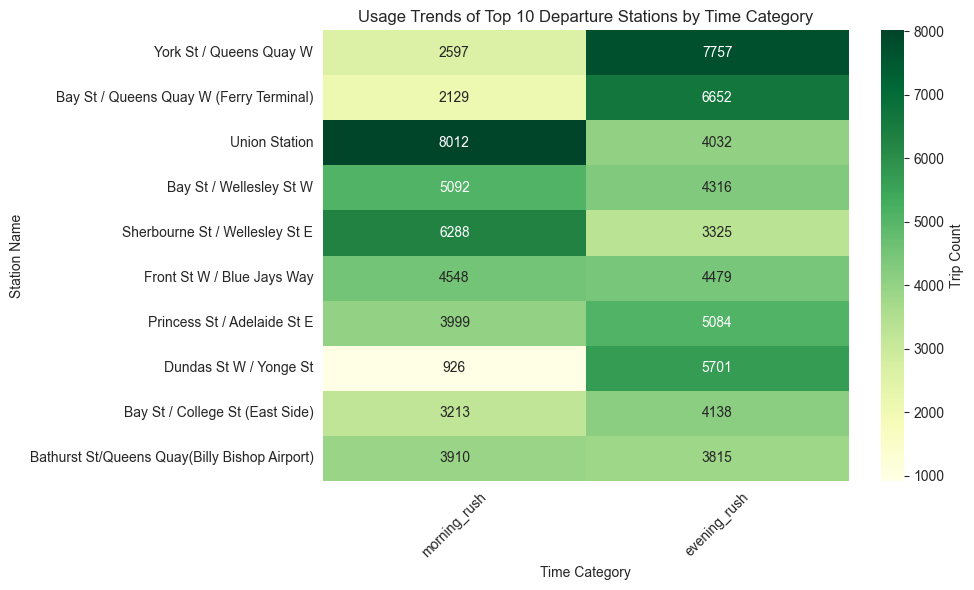

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(10, 6))
rush_heatmap_from_stations = sns.heatmap(usage_trends_from_station[['morning_rush', 'evening_rush']].head(10),
                       annot=True, fmt=".0f", cmap='YlGn', cbar_kws={'label': 'Trip Count'})

plt.title('Usage Trends of Top 10 Departure Stations by Time Category')
plt.xlabel('Time Category')
plt.ylabel('Station Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

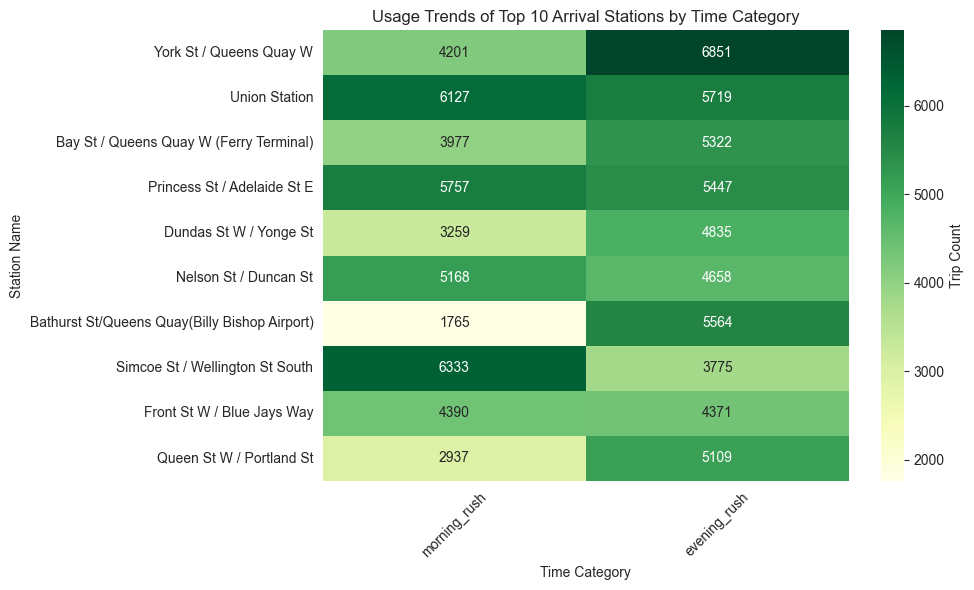

In [ ]:
# Plotting the heatmap
plt.figure(figsize=(10, 6))
rush_heatmap_to_stations = sns.heatmap(usage_trends_to_station[['morning_rush', 'evening_rush']].head(10),
                       annot=True, fmt=".0f", cmap='YlGn', cbar_kws={'label': 'Trip Count'})

plt.title('Usage Trends of Top 10 Arrival Stations by Time Category')
plt.xlabel('Time Category')
plt.ylabel('Station Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Peak stations

In [ ]:
morning_rush_starting_stations = usage_trends_from_station[usage_trends_from_station["morning_rush_pct"] > 50].sort_values(by='morning_rush_pct', ascending=False)[["morning_rush_pct"]]
morning_rush_ending_stations   = usage_trends_to_station[usage_trends_to_station["morning_rush_pct"] > 50].sort_values(by='morning_rush_pct', ascending=False)[["morning_rush_pct"]]

evening_rush_starting_stations = usage_trends_from_station[usage_trends_from_station["evening_rush_pct"] > 50].sort_values(by='evening_rush_pct', ascending=False)[["evening_rush_pct"]]
evening_rush_ending_stations   = usage_trends_to_station[usage_trends_to_station["evening_rush_pct"] > 50].sort_values(by='evening_rush_pct', ascending=False)[["evening_rush_pct"]]

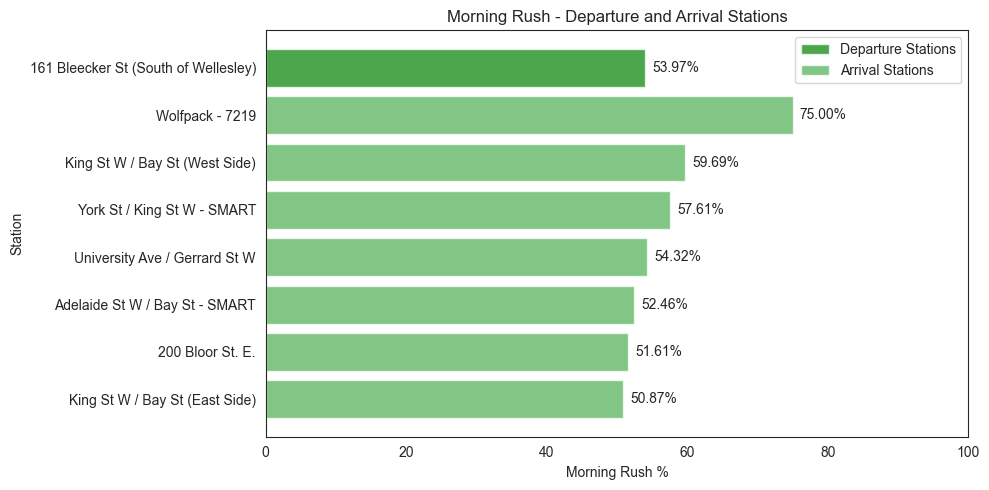

In [ ]:
# Plotting Morning Rush Start Stations
plt.figure(figsize=(10, 5))

# Horizontal bar for starting stations
plt.barh(morning_rush_starting_stations.index, morning_rush_starting_stations["morning_rush_pct"], label='Departure Stations', color="green", alpha=0.7)

# Horizontal bar for ending stations
plt.barh(morning_rush_ending_stations.index, morning_rush_ending_stations["morning_rush_pct"], label='Arrival Stations', color=green_color, alpha=0.7)

plt.title('Morning Rush - Departure and Arrival Stations')
plt.xlabel('Morning Rush %')
plt.ylabel('Station')
plt.legend(loc='upper right')
plt.xlim(0, 100)  # Set x-axis limit for better visibility

# Adding data labels for starting stations
for index, value in enumerate(morning_rush_starting_stations["morning_rush_pct"]):
    plt.text(value+1, index, f'{value:.2f}%', va='center')  # Add an offset of 1 for better alignment

# Adding data labels for ending stations
for index, value in enumerate(morning_rush_ending_stations["morning_rush_pct"]):
    plt.text(value+1, index+1, f'{value:.2f}%', va='center')  # Add an offset of 1 for better alignment

# Invert the y-axis to have higher values on top
plt.gca().invert_yaxis()  

plt.tight_layout()
plt.show()

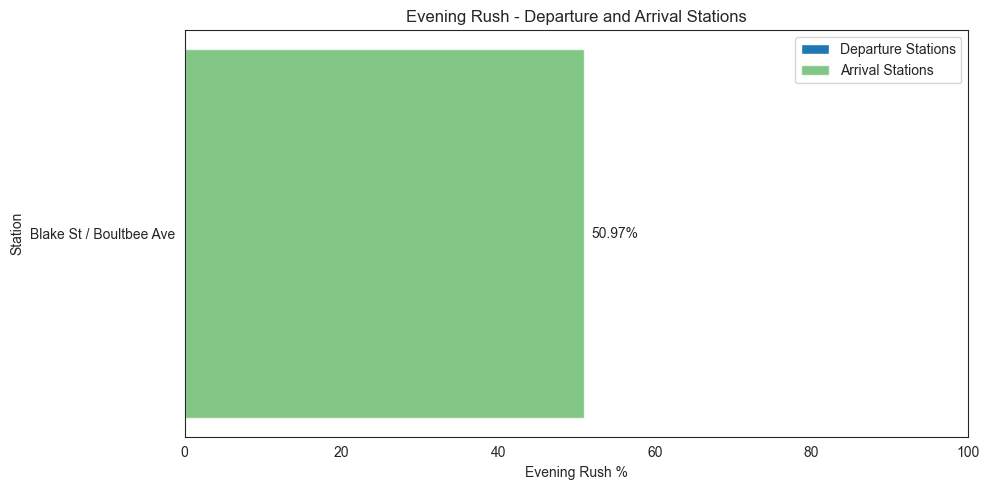

In [ ]:
# Plotting Evening Rush Start Stations
plt.figure(figsize=(10, 5))

# Horizontal bar for starting stations
plt.barh(evening_rush_starting_stations.index, evening_rush_starting_stations["evening_rush_pct"], label='Departure Stations', color='lightgreen', alpha=0.7)

# Horizontal bar for ending stations
plt.barh(evening_rush_ending_stations.index, evening_rush_ending_stations["evening_rush_pct"], label='Arrival Stations', color=green_color, alpha=0.7)

plt.title('Evening Rush - Departure and Arrival Stations')
plt.xlabel('Evening Rush %')
plt.ylabel('Station')
plt.legend(loc='upper right') 
plt.xlim(0, 100)  # Set x-axis limit for better visibility

# Adding data labels for starting stations
for index, value in enumerate(evening_rush_starting_stations["evening_rush_pct"]):
    plt.text(value+1, index+1, f'{value:.2f}%', va='center')  # Add an offset of 1 for better alignment

# Adding data labels for ending stations
for index, value in enumerate(evening_rush_ending_stations["evening_rush_pct"]):
    plt.text(value+1, index, f'{value:.2f}%', va='center')  # Add an offset of 1 for better alignment

# Invert the y-axis to have higher values on top
plt.gca().invert_yaxis()  

plt.tight_layout()
plt.show()


### Weekdays vs. Weekends

In [ ]:
# Group by station and time category
weekday_weekend_usage_trends = trips_df.groupby(['from_station_name', 'is_weekend']).size().unstack(fill_value=0)

# Add a column for row totals
weekday_weekend_usage_trends['total_trips'] = weekday_weekend_usage_trends.sum(axis=1)

# Renaming columns
weekday_weekend_usage_trends.rename(columns={'No': 'weekday', 'Yes': 'weekend'}, inplace=True)

weekday_weekend_usage_trends["weekday_pct"] = round(weekday_weekend_usage_trends["weekday"]/weekday_weekend_usage_trends["total_trips"]*100, 2)
weekday_weekend_usage_trends["weekend_pct"] = round(weekday_weekend_usage_trends["weekend"]/weekday_weekend_usage_trends["total_trips"]*100, 2)

weekday_weekend_usage_trends = weekday_weekend_usage_trends.sort_values("total_trips", ascending=False)
weekday_weekend_usage_trends.head(2)

is_weekend,weekday,weekend,total_trips,weekday_pct,weekend_pct
from_station_name,,,,,
York St / Queens Quay W,17100,6917,24017,71.20,28.80
Bay St / Queens Quay W (Ferry Terminal),15492,7251,22743,68.12,31.88


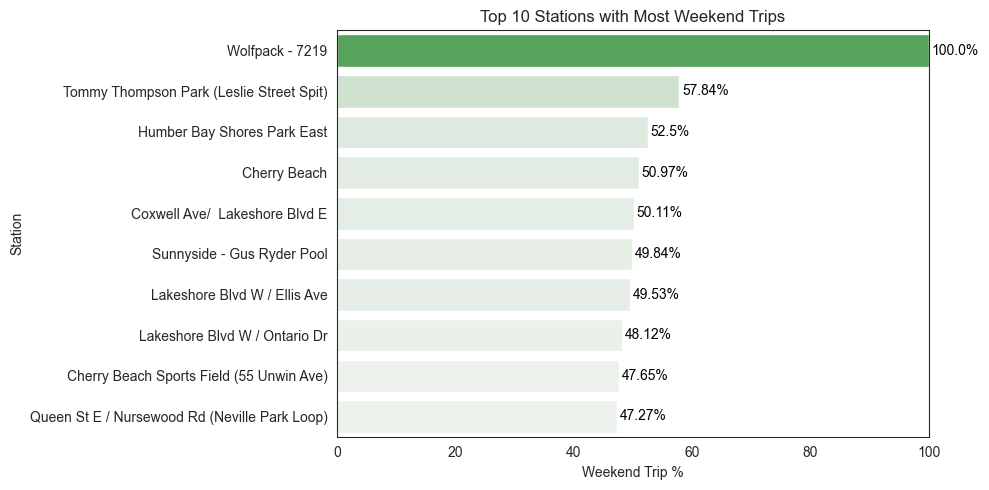

In [ ]:
# Prepare the data, ensuring we are only working with the top 10 stations by weekend_pct
data = weekday_weekend_usage_trends.sort_values(by='weekend_pct', ascending=False).head(10)

plt.figure(figsize=(10, 5))

bars = sns.barplot(x='weekend_pct', y='from_station_name', data=data, palette="light:"+green_color, hue='weekend_pct', legend=False)

for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, str(width)+"%", ha='left', va='center', fontsize=10, color='black')

plt.title('Top 10 Stations with Most Weekend Trips')
plt.xlabel('Weekend Trip %')
plt.ylabel('Station')
plt.xlim(0, 100)  # Set x-axis limit for better visibility
plt.tight_layout()
plt.show()

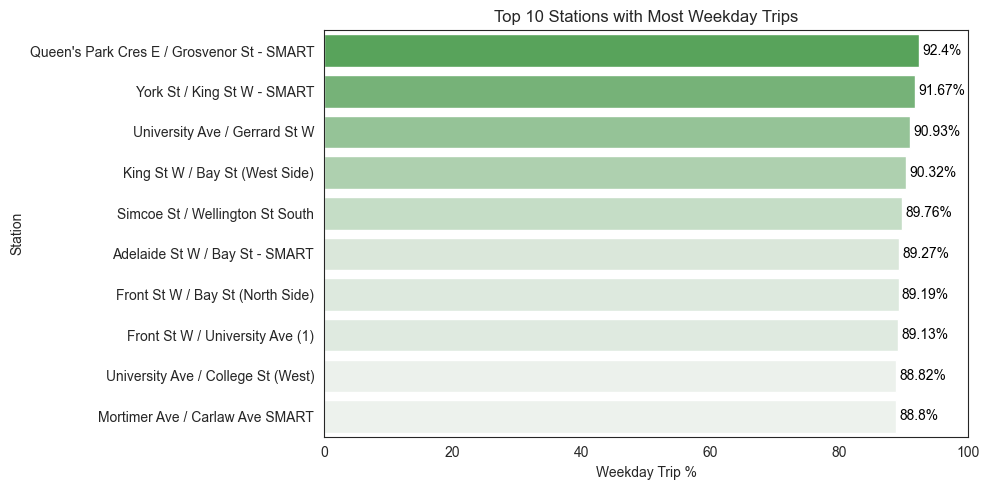

In [ ]:
# Prepare the data, ensuring we are only working with the top 10 stations by weekend_pct
data = weekday_weekend_usage_trends.sort_values(by='weekday_pct', ascending=False).head(10)

plt.figure(figsize=(10, 5))

bars = sns.barplot(x='weekday_pct', y='from_station_name', data=data, palette="light:"+green_color, hue='weekday_pct', legend=False)

for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height() / 2, str(width)+"%", ha='left', va='center', fontsize=10, color='black')

plt.title('Top 10 Stations with Most Weekday Trips')
plt.xlabel('Weekday Trip %')
plt.ylabel('Station')
plt.xlim(0, 100)  # Set x-axis limit for better visibility
plt.tight_layout()
plt.show()

# 3. User Behaviour Analysis

### Total trips by user type

In [ ]:
# Group by user_type and total trips of stations
trips_by_user_type = trips_df.groupby(['user_type', 'from_station_name']).size().reset_index(name="total_trips").sort_values(by='total_trips', ascending=False)

# Get total trips by member type
total_trips_by_active_members = trips_by_user_type[trips_by_user_type["user_type"] == 1]["total_trips"].sum()
total_trips_by_casual_members = trips_by_user_type[trips_by_user_type["user_type"] == 0]["total_trips"].sum()

top_trips_by_active_members = trips_by_user_type[trips_by_user_type["user_type"] == 1].head(10)
top_trips_by_casual_members = trips_by_user_type[trips_by_user_type["user_type"] == 0].head(10)

top_trips_by_active_members["total_trips_pct"] = round(top_trips_by_active_members["total_trips"]/total_trips_by_active_members*100, 2)
top_trips_by_casual_members["total_trips_pct"] = round(top_trips_by_casual_members["total_trips"]/total_trips_by_casual_members*100, 2)

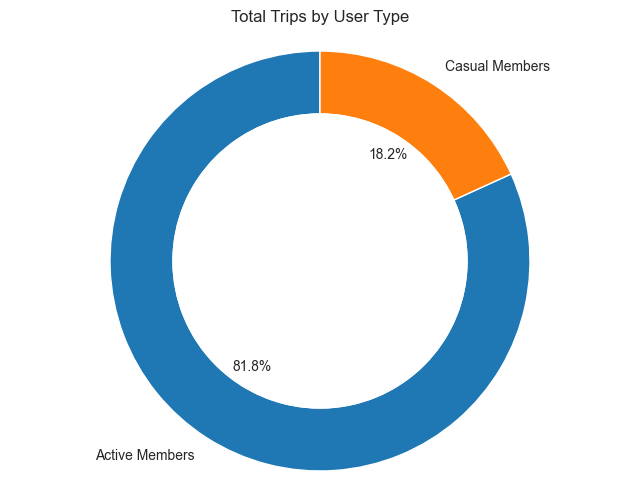

In [ ]:
# Create a pie chart
plt.figure(figsize=(8, 6))

data = {
    'User Type': ['Active Members', 'Casual Members'],
    'Total Trips': [total_trips_by_active_members, total_trips_by_casual_members]
}
df_donut = pd.DataFrame(data)

plt.pie(df_donut['Total Trips'], labels=df_donut['User Type'], startangle=90, autopct='%1.1f%%', wedgeprops=dict(width=0.3))

# Draw a circle in the center of the pie to make it a donut chart
centre_circle = plt.Circle((0, 0), 0.70, color='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
plt.title('Total Trips by User Type')
plt.show()

### Average duration of trip by user tpye

Did in Question 1.5

### Popular station by user type

In [ ]:
total_trips_by_active_members = trips_by_user_type[trips_by_user_type["user_type"] == 1]["total_trips"].sum()
total_trips_by_active_members

1572980

In [ ]:
total_trips_by_casual_members = trips_by_user_type[trips_by_user_type["user_type"] == 0]["total_trips"].sum()
total_trips_by_casual_members

349975

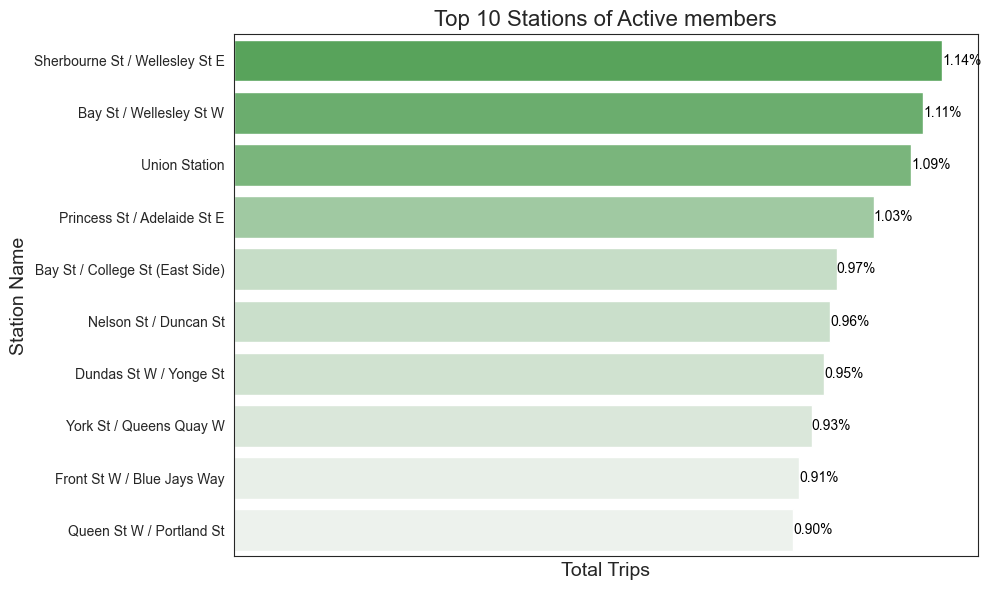

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style('white')

bars = sns.barplot(x='total_trips_pct', y='from_station_name', data=top_trips_by_active_members, palette="light:"+green_color, hue='total_trips', legend=False)

# Annotate bars with the average duration data labels
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f"{width:.2f}%", ha='left', va='center', fontsize=10, color='black')

# Set titles and labels
plt.title('Top 10 Stations of Active members', fontsize=16)
plt.xlabel('Total Trips', fontsize=14)
plt.ylabel('Station Name', fontsize=14)
plt.xticks([]) # Hide x ticks
plt.tight_layout()
plt.show()

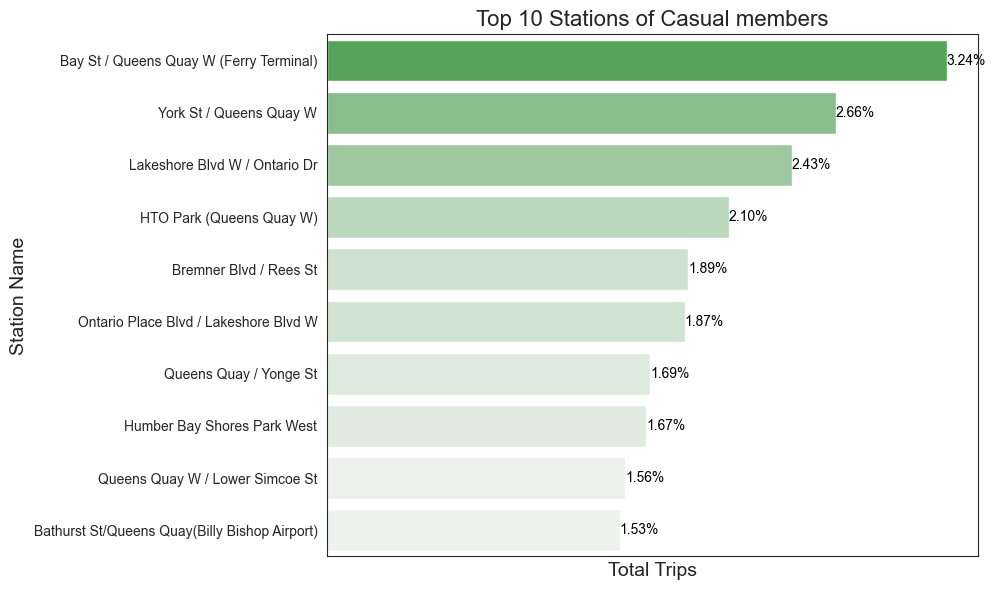

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style('white')

bars = sns.barplot(x='total_trips_pct', y='from_station_name', data=top_trips_by_casual_members, palette="light:"+green_color, hue='total_trips', legend=False)

# Annotate bars with the average duration data labels
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f"{width:.2f}%", ha='left', va='center', fontsize=10, color='black')

# Set titles and labels
plt.title('Top 10 Stations of Casual members', fontsize=16)
plt.xlabel('Total Trips', fontsize=14)
plt.ylabel('Station Name', fontsize=14)
plt.xticks([]) # Hide x ticks
plt.tight_layout()
plt.show()

In [ ]:
# Group by user_type and calculate the mean trip duration for each type
average_trip_duration_by_user_type = trips_df.groupby('user_type')['trip_duration_minutes'].mean().reset_index()

overall_average_trip_duartion = trips_df["trip_duration_minutes"].mean()

# Get total trips by member type 
average_trip_duration_active_members = average_trip_duration_by_user_type[average_trip_duration_by_user_type["user_type"] == 1]["trip_duration_minutes"].mean()
average_trip_duration_casual_members = average_trip_duration_by_user_type[average_trip_duration_by_user_type["user_type"] == 0]["trip_duration_minutes"].mean()
average_trip_duration_active_members

12.083614858421594

In [ ]:
# Group by hour, day of the week and month of the time and calculate count of trips by user type
hourly_trip_count  = trips_df.groupby(['trip_start_hour', 'user_type'])
weekday_trip_count = trips_df.groupby(['trip_start_day_of_week', 'user_type'])
monthly_trip_count = trips_df.groupby(['trip_start_month', 'user_type'])

hourly_trip_count  = hourly_trip_count.size().reset_index(name='total_trips')
weekday_trip_count = weekday_trip_count.size().reset_index(name='total_trips')
monthly_trip_count = monthly_trip_count.size().reset_index(name='total_trips')

C:\Users\mohit\AppData\Local\Temp\ipykernel_4576\906325057.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_trip_count = trips_df.groupby(['trip_start_day_of_week', 'user_type'])
C:\Users\mohit\AppData\Local\Temp\ipykernel_4576\906325057.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_trip_count = trips_df.groupby(['trip_start_month', 'user_type'])


In [ ]:
weekday_trip_count.columns

Index(['trip_start_day_of_week', 'user_type', 'total_trips'], dtype='object')

In [ ]:
# Group by day of the week and user_type, and calculate total trips
weekday_trip_count = trips_df.groupby(['trip_start_day_of_week', 'user_type']).size().reset_index(name='total_trips')

# Calculate the total trips per day
total_trips_per_day = weekday_trip_count.groupby('trip_start_day_of_week')['total_trips'].transform('sum')

# Calculate the percentage of trips by user type for each day
weekday_trip_count['percentage'] = (weekday_trip_count['total_trips'] / total_trips_per_day) * 100

C:\Users\mohit\AppData\Local\Temp\ipykernel_4576\454218840.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekday_trip_count = trips_df.groupby(['trip_start_day_of_week', 'user_type']).size().reset_index(name='total_trips')
C:\Users\mohit\AppData\Local\Temp\ipykernel_4576\454218840.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_trips_per_day = weekday_trip_count.groupby('trip_start_day_of_week')['total_trips'].transform('sum')


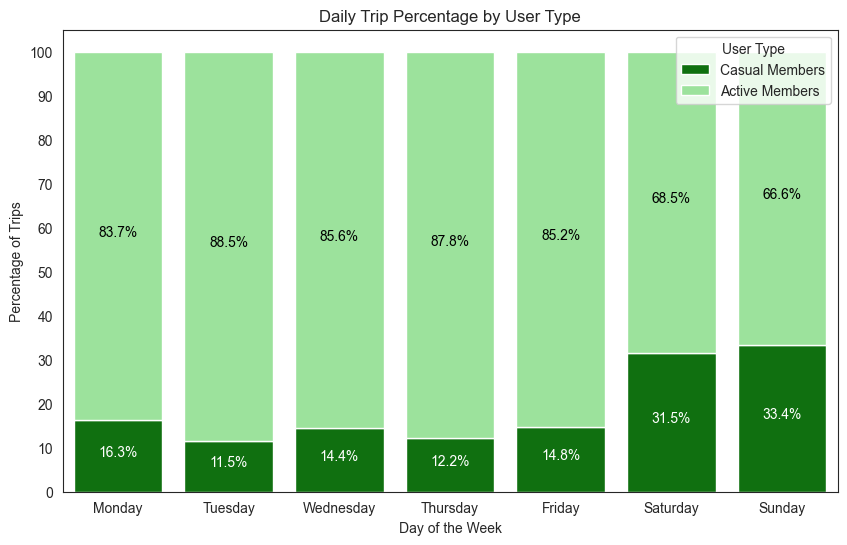

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the first bar for 'Casual Members' (user_type = 0)
sns.barplot(
    x='trip_start_day_of_week', y='percentage', 
    data=weekday_trip_count[weekday_trip_count['user_type'] == 0],
    label='Casual Members', color='green'
)

# Plot the second bar for 'Active Members' (user_type = 1) and stack it on top of the previous bar
sns.barplot(
    x='trip_start_day_of_week', y='percentage', 
    data=weekday_trip_count[weekday_trip_count['user_type'] == 1],
    label='Active Members', color='lightgreen',
    bottom=weekday_trip_count[weekday_trip_count['user_type'] == 0]['percentage'].values
)

# Adding data labels (percentage) on top of the stacked bars
for index, row in weekday_trip_count.iterrows():
    if row['user_type'] == 0:  # For Casual Members
        plt.text(row['trip_start_day_of_week'], row['percentage'] / 2, f'{row["percentage"]:.1f}%', ha='center', color='white')
    else:  # For Active Members, the label goes above the first bar
        bottom_height = weekday_trip_count[(weekday_trip_count['trip_start_day_of_week'] == row['trip_start_day_of_week']) & (weekday_trip_count['user_type'] == 0)]['percentage'].values[0]
        plt.text(row['trip_start_day_of_week'], bottom_height + row['percentage'] / 2, f'{row["percentage"]:.1f}%', ha='center', color='black')

# Adding labels and title
plt.title('Daily Trip Percentage by User Type')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage of Trips')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.yticks(range(0, 101, 10))  # Y-axis percentage from 0 to 100
plt.legend(title='User Type')
plt.show()


# 4. Time-Series Analysis

## Trips by Month and Day of the Week

C:\Users\mohit\AppData\Local\Temp\ipykernel_4576\907716513.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = trips_df.groupby([trips_df['trip_start_month'], trips_df['trip_start_day_of_week']])['trip_id'].count().unstack()


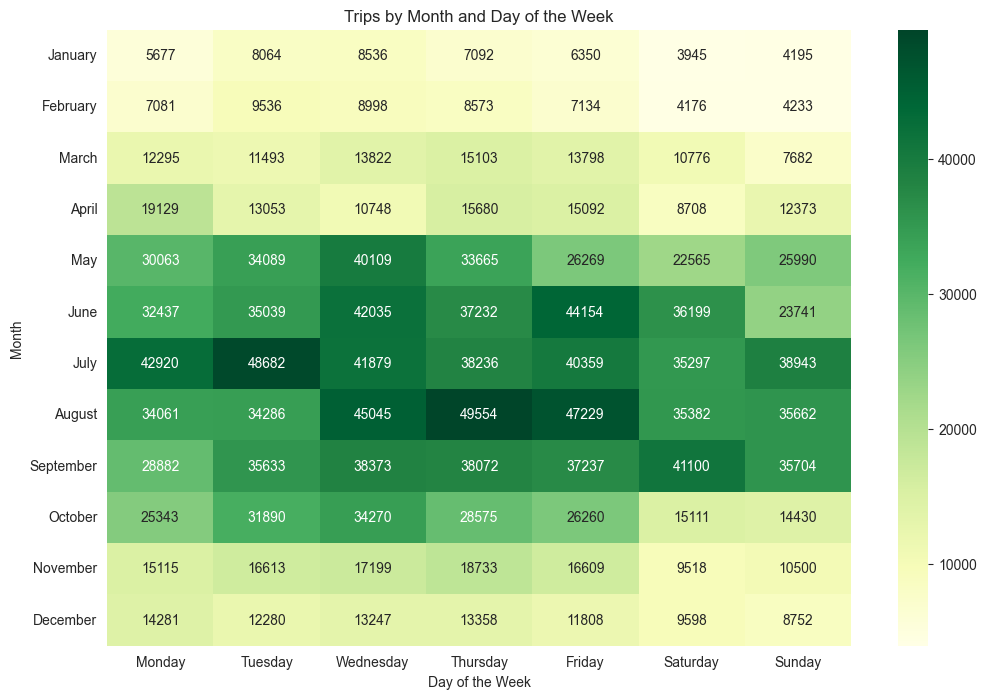

In [ ]:
# Group by both month and day of the week
data = trips_df.groupby([trips_df['trip_start_month'], trips_df['trip_start_day_of_week']])['trip_id'].count().unstack()

# Visualize using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data, cmap='YlGn', annot=True, fmt='d')

# Adding labels and title
plt.title('Trips by Month and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Month')
plt.show()


## Trips by Hour and Day of the Week

C:\Users\mohit\AppData\Local\Temp\ipykernel_4576\3124655133.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = trips_df.groupby([trips_df["trip_start_hour"], trips_df["trip_start_day_of_week"]])['trip_id'].count().unstack()


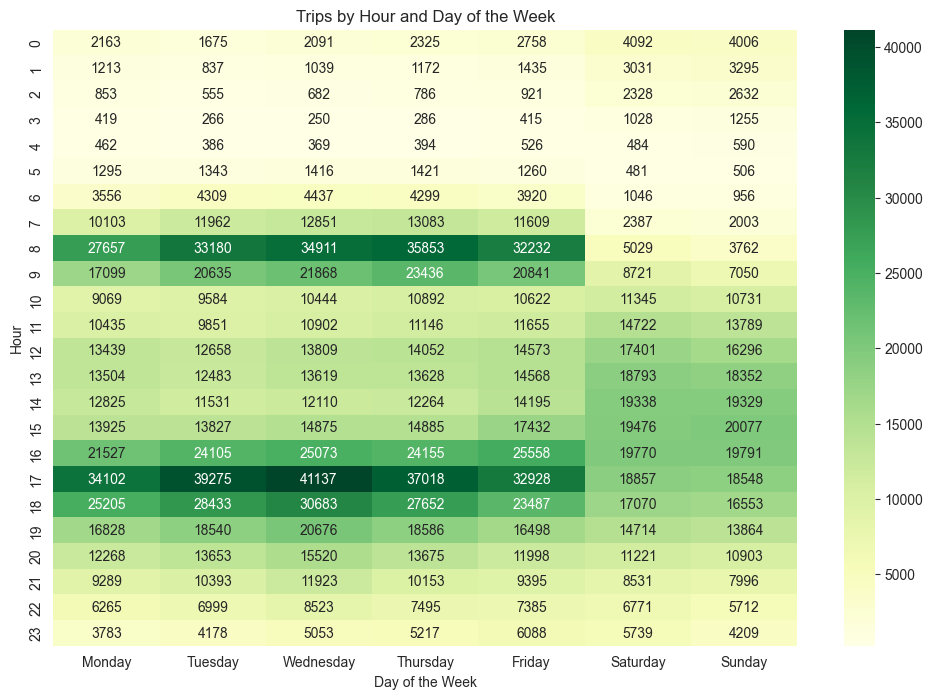

In [ ]:
# Group by both weekday and hour
data = trips_df.groupby([trips_df["trip_start_hour"], trips_df["trip_start_day_of_week"]])['trip_id'].count().unstack()

# Visualize using a heatmap to capture trends over time
plt.figure(figsize=(12, 8))
sns.heatmap(data, cmap='YlGn', annot=True, fmt='d')
plt.title('Trips by Hour and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour')
plt.show()

## Trips by Month and Hour

C:\Users\mohit\AppData\Local\Temp\ipykernel_4576\3418535408.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = trips_df.groupby([trips_df['trip_start_month'], trips_df['trip_start_hour']])['trip_id'].count().unstack()


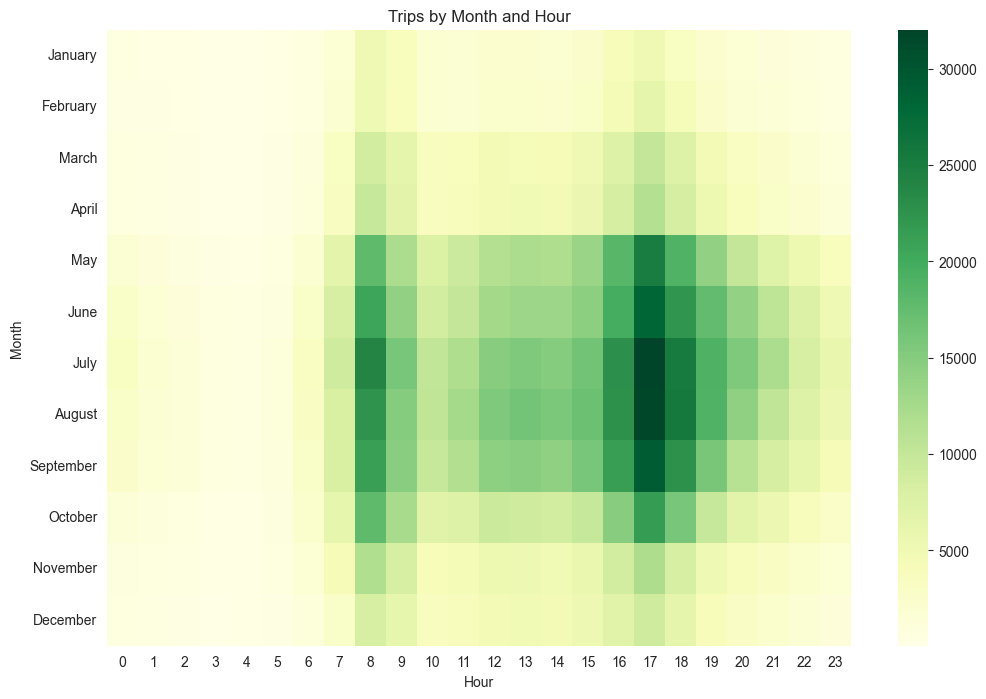

In [ ]:
# Group by both month and hour
data = trips_df.groupby([trips_df['trip_start_month'], trips_df['trip_start_hour']])['trip_id'].count().unstack()

# Visualize using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data, cmap='YlGn', annot=False, fmt='d')

# Adding labels and title
plt.title('Trips by Month and Hour')
plt.xlabel('Hour')
plt.ylabel('Month')
plt.show()

In [32]:
trips_df.dtypes

trip_id                            int64
trip_duration_seconds              int64
from_station_id                    int64
trip_start_time           datetime64[ns]
from_station_name                 object
trip_stop_time            datetime64[ns]
to_station_id                      int64
to_station_name                   object
user_type                          int64
from_lat                         float64
from_lon                         float64
to_lat                           float64
to_lon                           float64
trip_start_hour                    int32
trip_start_day_of_week          category
trip_start_month                category
is_weekend                        object
trip_time_category                object
trip_duration_minutes            float64
dtype: object

## Station Demand Forecasting Model (SDFM)

Initialy, I added the granulity of model to minute level, which gave me shape of **(86849280, 7)** of `sdfm_df`.

My PC did not had enough RAM to handle so I decided to remove minute by minute detail, or I can divide Hour by four 15-minutes interval.

Get minutes of trip_start_time

In [33]:
trips_df["trip_start_minute"] = trips_df["trip_start_time"].dt.minute

Target Encoding

Target Encoding provides a single feature per station that represents a meaningful summary, such as here taking the count of trips at that station, making it suitable for linear models.

In [34]:
sdfm_df = trips_df[['from_station_id', 'trip_start_minute', 'trip_start_hour', 'trip_start_day_of_week', 'trip_start_month', 'user_type']]
sdfm_df.head()

,from_station_id,trip_start_minute,trip_start_hour,trip_start_day_of_week,trip_start_month,user_type
0,7018,47,0,Monday,January,1
22944,7248,59,14,Saturday,January,1
22943,7164,58,14,Saturday,January,1
22942,7016,58,14,Saturday,January,1
22941,7240,57,14,Saturday,January,1


In [35]:
# Define the 15-minute interval based on 'minute'
sdfm_df['minute_interval'] = pd.cut(
    sdfm_df['trip_start_minute'], 
    bins=[-1, 14, 29, 44, 59], 
    labels=['0_14', '15_29', '30_44', '45_59']
)

sdfm_df.drop(columns=['trip_start_minute'], inplace=True)
sdfm_df.reset_index(drop=True, inplace=True)
sdfm_df.head()

C:\Users\mohit\AppData\Local\Temp\ipykernel_15700\3951762769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdfm_df['minute_interval'] = pd.cut(
C:\Users\mohit\AppData\Local\Temp\ipykernel_15700\3951762769.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdfm_df.drop(columns=['trip_start_minute'], inplace=True)


,from_station_id,trip_start_hour,trip_start_day_of_week,trip_start_month,user_type,minute_interval
0,7018,0,Monday,January,1,45_59
1,7248,14,Saturday,January,1,45_59
2,7164,14,Saturday,January,1,45_59
3,7016,14,Saturday,January,1,45_59
4,7240,14,Saturday,January,1,45_59


In [36]:
sdfm_df.shape

(1922955, 6)

In [37]:
# Calculate total trips by station, hour, day_of_week, and month
sdfm_df = sdfm_df.groupby(['from_station_id', 'minute_interval', 'trip_start_hour', 'trip_start_day_of_week', 'trip_start_month', 'user_type']).size().reset_index(name='total_trips')
sdfm_df.columns = ['station_id', 'minute_interval', 'hour', 'day_of_week', 'month', 'user_type', 'total_trips']
sdfm_df.head()

C:\Users\mohit\AppData\Local\Temp\ipykernel_15700\2442589124.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sdfm_df = sdfm_df.groupby(['from_station_id', 'minute_interval', 'trip_start_hour', 'trip_start_day_of_week', 'trip_start_month', 'user_type']).size().reset_index(name='total_trips')


,station_id,minute_interval,hour,day_of_week,month,user_type,total_trips
0,7000,0_14,0,Monday,January,0,0
1,7000,0_14,0,Monday,January,1,0
2,7000,0_14,0,Monday,February,0,0
3,7000,0_14,0,Monday,February,1,0
4,7000,0_14,0,Monday,March,0,0


In [38]:
sdfm_df.shape

(5789952, 7)

In [39]:
sdfm_df.nunique()

station_id         359
minute_interval      4
hour                24
day_of_week          7
month               12
user_type            2
total_trips         47
dtype: int64

In [40]:
# Veirfying the total trips by matching with rows of trips_df
sdfm_df["total_trips"].sum() == trips_df.shape[0]

True

Sort dataframe at multiple levels

In [41]:
sdfm_df = sdfm_df.sort_values(by=['station_id', 'minute_interval', 'hour', 'day_of_week', 'month', 'user_type'], ascending=[True, True, True, True, True, True])
sdfm_df.head()

,station_id,minute_interval,hour,day_of_week,month,user_type,total_trips
0,7000,0_14,0,Monday,January,0,0
1,7000,0_14,0,Monday,January,1,0
2,7000,0_14,0,Monday,February,0,0
3,7000,0_14,0,Monday,February,1,0
4,7000,0_14,0,Monday,March,0,0


In [42]:
sdfm_df.dtypes

station_id            int64
minute_interval    category
hour                  int32
day_of_week        category
month              category
user_type             int64
total_trips           int64
dtype: object

Mapping

In [43]:
# Cyclic encoding for `day_of_week` (7-day cycle)
day_of_week_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
}

# Cyclic encoding for `month` (12-month cycle)
month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}

Creating dummy variable for minute_interval

In [44]:
# Use pandas get_dummies to create dummy variables for the 'minute_interval' column
minute_dummies = pd.get_dummies(sdfm_df['minute_interval'], prefix='minute')

# Concatenate the dummy variables with the original dataframe
sdfm_df = pd.concat([sdfm_df, minute_dummies], axis=1)

# Dropping original minute_interval column
sdfm_df = sdfm_df.drop('minute_interval', axis=1)

sdfm_df.head()

,station_id,hour,day_of_week,month,user_type,total_trips,minute_0_14,minute_15_29,minute_30_44,minute_45_59
0,7000,0,Monday,January,0,0,True,False,False,False
1,7000,0,Monday,January,1,0,True,False,False,False
2,7000,0,Monday,February,0,0,True,False,False,False
3,7000,0,Monday,February,1,0,True,False,False,False
4,7000,0,Monday,March,0,0,True,False,False,False


Encoding

In [45]:
# Cyclic encoding for `hour` (since it ranges from 0 to 23) to capture the circular nature of time
sdfm_df['hour_sin'] = np.sin(2 * np.pi * sdfm_df['hour'] / 24)
sdfm_df['hour_cos'] = np.cos(2 * np.pi * sdfm_df['hour'] / 24)


# Ensure 'day_of_week' is treated as a standard object type
sdfm_df['day_of_week'] = sdfm_df['day_of_week'].astype(str)
sdfm_df['day_of_week_num'] = sdfm_df['day_of_week'].map(day_of_week_map)

# Apply sine and cosine transformations
sdfm_df['day_of_week_sin'] = np.sin(2 * np.pi * sdfm_df['day_of_week_num'] / 7)
sdfm_df['day_of_week_cos'] = np.cos(2 * np.pi * sdfm_df['day_of_week_num'] / 7)


# Ensure 'month' is treated as a standard object type
sdfm_df['month'] = sdfm_df['month'].astype(str)
sdfm_df['month_num'] = sdfm_df['month'].map(month_map)

# Apply sine and cosine transformations
sdfm_df['month_sin'] = np.sin(2 * np.pi * sdfm_df['month_num'] / 12)
sdfm_df['month_cos'] = np.cos(2 * np.pi * sdfm_df['month_num'] / 12)


Dropping original columns

In [46]:
# Optional: Dropping the original columns if we only want to use the cyclic features
sdfm_df = sdfm_df.drop(columns=['hour', 'day_of_week', 'day_of_week_num', 'month', 'month_num'])

Converting to Boolean to Numerical values

In [47]:
# Convert boolean columns to numerical values (0 for False, 1 for True)
sdfm_df = sdfm_df.apply(lambda x: x.map({True: 1, False: 0}) if x.dtype == 'bool' else x)
sdfm_df.head()

,station_id,user_type,total_trips,minute_0_14,minute_15_29,minute_30_44,minute_45_59,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,7000,0,0,1,0,0,0,0.0,1.0,0.0,1.0,0.500000,8.660254e-01
1,7000,1,0,1,0,0,0,0.0,1.0,0.0,1.0,0.500000,8.660254e-01
2,7000,0,0,1,0,0,0,0.0,1.0,0.0,1.0,0.866025,5.000000e-01
3,7000,1,0,1,0,0,0,0.0,1.0,0.0,1.0,0.866025,5.000000e-01
4,7000,0,0,1,0,0,0,0.0,1.0,0.0,1.0,1.000000,6.123234e-17


Feature Scaling

Only Continous variables need scaling,
not Categorical, Dummy or Binary variables.

In [84]:
from sklearn.preprocessing import StandardScaler

# Select columns for scaling
# numerical_columns = ['total_trips', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']
numerical_columns = ['hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']

scaler = StandardScaler()
sdfm_df[numerical_columns] = scaler.fit_transform(sdfm_df[numerical_columns])

Splitting data into training and testing sets

In [85]:
from sklearn.model_selection import train_test_split

target_variable = "total_trips"

X = sdfm_df.drop(columns=[target_variable])
y = sdfm_df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Get sample data

In [86]:
# Get 10% of the data from the original dataframe
sampled_data = sdfm_df.sample(frac=0.005, random_state=42)

# If you want to separate features (X) and target variable (y)
X_sampled = sampled_data.drop(target_variable, axis=1)
y_sampled = sampled_data[target_variable]

# Split the sampled data into training and test sets (70% train, 30% test)
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)

print("Sample Size:", X_sampled.shape)

Sample Size: (28950, 12)


In [87]:
# # Calculate the correlation matrix
# corr_matrix = sdfm_df.corr()

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))  # Adjust the size of the plot
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": 0.8})

# # Set title and show the plot
# plt.title("Correlation Heatmap")
# plt.show()

## Random Forest Model

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

To find the best combination of `n_estimators` and `max_depth`, we can use `GridSearchCV`:

In [89]:
# # Set up the parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [10, 20]
# }

# # Initialize the model and GridSearchCV
# grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
#                            param_grid=param_grid, 
#                            scoring='neg_mean_absolute_error', 
#                            cv=3,
#                            n_jobs=1)

# # Fit the grid search to the training data
# # grid_search.fit(X_train, y_train)
# grid_search.fit(X_train_sampled, y_train_sampled)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

Initialize and train the model

In [90]:
rfg_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
# rfg_model.fit(X_train, y_train)
rfg_model.fit(X_train_sampled, y_train_sampled)

RandomForestRegressor(max_depth=10, n_estimators=200, random_state=42)

With 10% sample,    
time: 1:55.4 minutes,  
MAE for sampled data: 0.334,    
MSE for sampled data: 0.663,    
R² for sampled data:  0.340 

With 5% sample,     
time: 0:53.5 seconds,      
MAE for sampled data: 0.341,        
MSE for sampled data: 0.697,     
R² for sampled data:  0.348

With 1% sample,     
time: 0:10.3 seconds,    
MAE for sampled data: 0.343,    
MSE for sampled data: 0.710,    
R² for sampled data:  0.289

Evaluate the Model

In [91]:
# # Predict on test set
# y_pred = rfg_model.predict(X_test)

# # Calculate evaluation metrics
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"MAE: {mae}")
# print(f"MSE: {mse}")
# print(f"R²:  {r2}")

Evaluate sampled model

In [92]:
# Predict on test set using the sampled data
y_pred_sampled = rfg_model.predict(X_test_sampled)

# Calculate evaluation metrics for sampled data
mae_sampled = mean_absolute_error(y_test_sampled, y_pred_sampled)
mse_sampled = mean_squared_error(y_test_sampled, y_pred_sampled)
r2_sampled = r2_score(y_test_sampled, y_pred_sampled)

print(f"MAE for sampled data: {mae_sampled}")
print(f"MSE for sampled data: {mse_sampled}")
print(f"R² for sampled data: {r2_sampled}")


MAE for sampled data: 0.34946916971527314
MSE for sampled data: 0.7014958283961421
R² for sampled data: 0.3046845517513407


Predict using RFG Model

In [105]:
count = 5

# Generate random data for multiple iterations (e.g., generating 5 rows of data)
random_data = []

for _ in range(count):
    # Generate random data for each iteration
    random_num = np.random.uniform(0, 2, size=10).astype(int)
    
    # Ensure only one value in random_list is 1, and the rest are 0
    random_list = np.zeros(4, dtype=int)
    random_list[np.random.randint(0, 4)] = 1  # Randomly set one value to 1
    
    # Create a new dictionary of data for each row
    row_data = {
        'station_id': np.random.uniform(7000, 7392, size=1).astype(int)[0],
        'user_type': np.random.uniform(0, 2, size=1).astype(int)[0],
        'minute_0_14': random_list[0],
        'minute_15_29': random_list[1],
        'minute_30_44': random_list[2], 
        'minute_45_59': random_list[3],
        'hour_sin': np.random.uniform(-1, 1, size=1)[0],  # Random value for 'hour_sin'
        'hour_cos': np.random.uniform(-1, 1, size=1)[0],  # Random value for 'hour_cos'
        'day_of_week_sin': np.random.uniform(-1, 1, size=1)[0],  # Random value for 'day_of_week_sin'
        'day_of_week_cos': np.random.uniform(-1, 1, size=1)[0],  # Random value for 'day_of_week_cos'
        'month_sin': np.random.uniform(-1, 1, size=1)[0],  # Random value for 'month_sin'
        'month_cos': np.random.uniform(-1, 1, size=1)[0],  # Random value for 'month_cos'
    }
    
    # Append the row data to the list
    random_data.append(row_data)

# Create DataFrame
random_df = pd.DataFrame(random_data)

# Make predictions using the trained model
y_pred_random = rfg_model.predict(random_df)

# Output the predictions (scaled)
print("Predictions on new random data:", y_pred_random)

Predictions on new random data: [ 1.09565987 -0.13607946 -0.26578641 -0.11591563  0.85595422]


In [94]:
# Recover the original values for 'hour', 'day_of_week', 'month' from sin and cos
random_df['hour'] = np.arctan2(random_df['hour_sin'], random_df['hour_cos']) * (180 / np.pi)  # Convert from radians to degrees
random_df['day_of_week'] = np.arctan2(random_df['day_of_week_sin'], random_df['day_of_week_cos']) * (180 / np.pi)
random_df['month'] = np.arctan2(random_df['month_sin'], random_df['month_cos']) * (180 / np.pi)

# Make sure the values are within the correct range (0-23 for hour, 0-6 for day_of_week, 0-11 for month)
random_df['hour'] = (random_df['hour'] + 360) % 360  # Ensure the angle is in [0, 360)
random_df['hour'] = np.round(random_df['hour']) % 24  # Convert to hours (0-23)

random_df['day_of_week'] = (random_df['day_of_week'] + 360) % 360  # Ensure the angle is in [0, 360)
random_df['day_of_week'] = np.round(random_df['day_of_week']) % 7  # Convert to days of the week (0-6)

random_df['month'] = (random_df['month'] + 360) % 360  # Ensure the angle is in [0, 360)
random_df['month'] = np.round(random_df['month']) % 12  # Convert to months (0-11)

# Display the results
print(random_df[['station_id', 'hour', 'day_of_week', 'month', 'user_type']])

   station_id  hour  day_of_week  month  user_type
0        7091  20.0          2.0    8.0          0
1        7382  23.0          1.0    8.0          0
2        7015  16.0          1.0    1.0          1
3        7070  20.0          2.0   11.0          0
4        7139  21.0          4.0    9.0          0


## Linear Regression
Do not use this model without scaling features

In [61]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.3, random_state=42)

# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")


Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.5260424786966035
Mean Squared Error (MSE): 1.1005582732067467
Root Mean Squared Error (RMSE): 1.049074960718607
R-squared (R2): 0.11844617980720673


# Plot all stations' location

Station Network Map

In [139]:
import folium

# Create a Folium map centered around the average location of the stations
map_center = [bike_stations_df['lat'].mean(), bike_stations_df['lon'].mean()]
station_map = folium.Map(location=map_center, zoom_start=13)

# Add markers for each station
for index, row in bike_stations_df.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],
        popup=f'''
                <div style="width: 300px; padding: 10px; font-size: 14px;">
                    <strong>Name:</strong> {row["name"]}<br><br>
                    <strong>ID:</strong> {row["station_id"]}<br><br>
                    <strong>Location:</strong> {row['lat'], row["lon"]}<br><br>
                </div>
                ''', 
        max_width=350,
        icon=folium.Icon(color='blue')
    ).add_to(station_map)

# Save the map to an HTML file
# station_map.save('maps/station_network_2018.html')

station_map


Station Network Heatmap

In [ ]:
import folium
from folium.plugins import HeatMap

# Create a Folium map centered around the average location of the stations
map_center = [bike_stations_df['lat'].mean(), bike_stations_df['lon'].mean()]
station_map = folium.Map(location=map_center, zoom_start=13)

# Create a list of station locations
station_locations = bike_stations_df[['lat', 'lon']].values.tolist()

# Add a heatmap layer for station density
HeatMap(station_locations, radius=15).add_to(station_map)

# Save the map to an HTML file
# station_map.save('maps/station_network_heatmap_2018.html')

station_map


# Test data

In [ ]:
# List of locations with coordinates
locations = [
    ("Princess St / Adelaide St E", 43.652364279365386, -79.38072119893286),
    ("East Liberty St / Pirandello St", 43.639083, -79.414222),
    ("University Ave / College St (West)", 43.659944, -79.406389),
    ("The Royal Ontario Museum (Bloor St Entrance)", 43.668444, -79.405028),
    ("Portland St & Wellington St W", 43.642917, -79.405472),
    ("Wellesley St E / Yonge St (Green P)", 43.6655, -79.395278),
    ("Queen St W / James St", 43.652364279365386, -79.38072119893286),
    ("Yonge St / Harbour St", 43.64256307021582, -79.37620018149019),
    ("University Ave / Elm St", 43.656365196668915, -79.38781487252689),
    ("Stewart St / Bathurst St  - SMART", 43.64318006677627, -79.40220532120897),
    ("Parliament St / Gerrard St", 43.66190892497103, -79.36689083621276),
    ("Walton St / Elizabeth St - SMART", 43.65775951515591, -79.38605778701378),
    ("Queen St E / George St (Moss Park)", 43.65391112056363, -79.37194228233268),
    ("Huron / Harbord St", 43.663701672289875, -79.40005460166932),
    ("Cherry St / Mill St", 43.65131162754315, -79.35721626639824),
    ("Queen St W / Shaw St", 43.64466219786213, -79.41611373593442),
    ("Borden St / Bloor St W - SMART", 43.66572398943307, -79.40878207642875),
    ("College St / McCaul St", 43.65911010024858, -79.39345145632274),
    ("Queen St W / Close Ave", 43.64070304242879, -79.4359587134529),
    ("Bloor GO / UP Station (West Toronto Railpath)", 43.656427257520185, -79.45167849957652),
    ("Simcoe St / Adelaide St W", 43.64860574452701, -79.3864666429806),
    ("King St W / Portland St", 43.644389289112645, -79.40065141953072),
    ("Marlborough Ave / Yonge St", 43.67994219829935, -79.38995166624743),
    ("Dovercourt Rd / Harrison St (Green P) - SMART", 43.65047864724172, -79.42425799717319),
    ("Pape Subway Green P", 43.68021607325339, -79.34413045292051),
    ("Roxborough St W / Yonge St", 43.67807392458066, -79.390372189717),
    ("Lee Ave / Queen St E", 43.6699549059716, -79.29785451573214),
    ("Dupont St / Emerson Ave - SMART", 43.6671597202503, -79.44423150877314),
    ("Wolfpack - 7219", 43.639445987085494, -79.42360693630165),
]

Plot trips circle size relatively to min and max.

In [ ]:
# Normalize the trip counts to scale the circle sizes
min_radius = 5  # Minimum size for the smallest circle
max_radius = 50  # Maximum size for the largest circle
min_trips = demand_start['total_trips'].min()  # Minimum total trips in the dataset
max_trips = demand_start['total_trips'].max()  # Maximum total trips in the dataset

# Function to normalize trip counts to a size between min_radius and max_radius
def normalize_trips(trips, min_trips, max_trips, min_radius, max_radius):
    return ((trips - min_trips) / (max_trips - min_trips)) * (max_radius - min_radius) + min_radius

# Calculate the map center based on the mean latitude and longitude of the first 10 stations
map_center = [demand_start['from_lat'].head(10).mean(), demand_start['from_lon'].head(10).mean()]

# Create a folium map centered at the calculated mean
station_map = folium.Map(location=map_center, zoom_start=13)

# Iterate over the first 10 stations and add markers
for index, row in demand_start.head(10).iterrows():
    if pd.notna(row['from_lat']) and pd.notna(row['from_lon']):  # Check if lat/lon values are valid
        trip_color = get_random_predefined_color() 
        
        # Add a marker for the start station
        folium.Marker(
            location=[row['from_lat'], row['from_lon']],
            popup=f"Name: {row['station']}, Total Trips: {row['total_trips']}", 
            icon=folium.Icon(color=trip_color, icon='bicycle', prefix='fa') 
        ).add_to(station_map)

        # Normalize the total_trips to a relative circle size
        circle_radius = normalize_trips(row['total_trips'], min_trips, max_trips, min_radius, max_radius)

        # Add a circle marker with a radius proportional to total_trips
        folium.CircleMarker(
            location=[row['from_lat'], row['from_lon']],  # Corrected to use the actual latitude and longitude
            radius=circle_radius,  # Use normalized radius
            color="cornflowerblue",
            stroke=False,
            fill=True,
            fill_opacity=0.6,
            # popup="Trips: {}".format(row['total_trips']),
            popup=f"Name: {row['station']}, Total Trips: {row['total_trips']}", 
            tooltip="{} trips".format(row['total_trips']),
        ).add_to(station_map)

# Display the map with markers for the first 10 stations
station_map


In [ ]:
from haversine import haversine, Unit

# Coordinates of the two bike stations (latitude, longitude)
lat1, lon1 = 40.76727216, -73.99392888
lat2, lon2 = 43.64256307021582, -79.37620018149019

station_1_coords = (lat1, lon1)  # Replace with the actual coordinates of station 1
station_2_coords = (lat2, lon2)  # Replace with the actual coordinates of station 2

# Calculate the distance in kilometers
distance_km = haversine(station_1_coords, station_2_coords, unit=Unit.KILOMETERS)

print(f"The distance between the two stations is {distance_km:.2f} km")

The distance between the two stations is 546.39 km


## Important links:

Grouping markers: https://python-visualization.github.io/folium/latest/getting_started.html#Grouping-and-controlling    
Chloropleth maps: https://python-visualization.github.io/folium/latest/getting_started.html#Choropleth-maps     
HTML in Popup:    https://python-visualization.github.io/folium/latest/user_guide/ui_elements/popups.html#HTML-in-popup    
GeoJSON:          https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html   
Plugins:          https://python-visualization.github.io/folium/latest/user_guide/plugins.html